# Modified TPC-H Q1 Microbenchmark
This file is adapted to use numpy only without Spark.

```sql
select
  sum(l_quantity) as sum_qty,
  sum(l_extendedprice) as sum_base_price,
  sum(l_extendedprice * (1 - l_discount)) as sum_disc_price,
  sum(l_extendedprice * (1 - l_discount) * (1 + l_tax)) as sum_charge,
  avg(l_quantity) as avg_qty,
  avg(l_extendedprice) as avg_price,
  avg(l_discount) as avg_disc,
  count(*) as count_order
from
  lineitem
where
  l_shipdate <= '1998-09-02'
  and l_returnflag = 'A'
  and l_linestatus = 'F'
```

In [371]:
EXPERIMENT = 'pac-q1-svd'
OUTPUT_DIR = f'./outputs/{EXPERIMENT}'
GENERATE = True
USE_EVEN_NUMBER_OF_INPUT_ROWS = False
SEED_RANDOM_NUMBER_GENERATOR = True

SAMPLING_METHOD = 'poisson' # 'poisson' or 'half'

if GENERATE:
    print("GENERATE = True, so we will generate new samples.")
else:
    print("GENERATE = False, so we will load saved output from files rather than recomputing.")

import os
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)


GENERATE = True, so we will generate new samples.


### Running PAC

In [372]:
from typing import Any, Callable, Dict, List, Tuple, Union

import numpy as np
if SEED_RANDOM_NUMBER_GENERATOR:
    np.random.seed(0)

import pandas as pd
from pandas import DataFrame
import concurrent.futures
import pyarrow as pa
import pyarrow.parquet as pq
import pickle
from numpy.random import laplace
from functools import reduce
import operator
from IPython.display import display, HTML
from datetime import date
from scipy import special

In [373]:
### Mayuri's conversion functions between DP epsilon and PAC MI using posterior advantage for equivalence
def calc_posterior(mi, prior=0.5, prec = 100000):
    test_vals = [x / prec for x in range(1, prec)]
    max_t = None
    for t in test_vals:
        if t*np.log(t/prior)+(1-t)*np.log((1-t)/(1-prior)) <= mi:
            if  max_t is None or t > max_t:
                max_t = t
    return max_t

def dp_epsilon_to_posterior_success(epsilon):
    return 1 - 1./(1+np.exp(epsilon))

def dp_ps_to_epsilon(ps):
    return np.log(ps / (1-ps))

# example usage:
# dp_ps_to_epsilon(calc_posterior(1/256.))

In [374]:
### Data Setup
lineitem_df = pd.read_parquet('data/tpch/lineitem.parquet')

lineitem_df.shape

(600572, 16)

In [375]:
type(lineitem_df['l_linestatus'][0])

str

In [376]:
def runquery(lineitem_df: DataFrame) -> int:
    # 1. Filter lineitem rows where commit date is before receipt date.
    lineitem_filtered = lineitem_df[
        (lineitem_df['l_shipdate'] <= date(1998, 9, 2)) &
        (lineitem_df['l_returnflag'] == 'A') &
        (lineitem_df['l_linestatus'] == 'F')
    ]
    print(lineitem_filtered.shape)

    # 2. Pre-compute
    discounted_price = lineitem_filtered['l_extendedprice'] * (1 - lineitem_filtered['l_discount'])
    charged_price = discounted_price * (1 + lineitem_filtered['l_tax'])

    # 3. Get aggregations
    aggregated_result = [
        float(lineitem_filtered['l_quantity'].sum()),       # sum_qty
        float(lineitem_filtered['l_extendedprice'].sum()),  # sum_base_price
        float(discounted_price.sum()),                      # sum_disc_price
        float(charged_price.sum()),                         # sum_charge
        float(lineitem_filtered['l_quantity'].mean()),      # avg_qty
        float(lineitem_filtered['l_extendedprice'].mean()), # avg_price
        float(lineitem_filtered['l_discount'].mean()),      # avg_disc
        float(len(lineitem_filtered))                       # count_order (faster than .count())
    ]

    # print(aggregated_result)

    return aggregated_result
runquery(lineitem_df)

(147790, 16)


[3774200.0,
 5320753880.69,
 5054096266.6828,
 5256751331.449234,
 25.537587116854997,
 36002.12382901414,
 0.05014459706340077,
 147790.0]

In [377]:
### Query Setup
SAMPLES = 8192
assert SAMPLES % 2 == 0, "We need an even number of samples for paired sampling."
number_of_pairs = SAMPLES // 2

OUTPUT_COLS = ['sum_qty', 'sum_base_price', 'sum_disc_price', 'sum_charge', 'avg_qty', 'avg_price', 'avg_disc', 'count_order']

true_result = np.array(runquery(lineitem_df)) # Save the true result of the query for later

number_of_contributing_rows = 147790  # hardcode number of eligible rows

def poisson_paired_sample(df: DataFrame) -> Tuple[DataFrame, DataFrame]:
    """
    This will select a subset of indices, where each index is selected with probability 0.5.
    The first result is the dataframe composed of the selected rows.
    The second result is the complement / the dataframe composed of the rows that were not selected.
    """
    mask = np.random.random_sample(len(df)) < 0.5  # Generates a bitmask of length df.shape[0] where each bit is 1 with probability 0.5
    selected = df[mask]
    not_selected = df[~mask]
    return selected, not_selected

def half_paired_sample(df: DataFrame) -> Tuple[DataFrame, DataFrame]:
    """
    This will select half of the row indices from the dataframe at random.
    The first result is the dataframe composed of the selected rows.
    The second result is the complement / the dataframe composed of the rows that were not selected.
    """
    indices = np.random.choice(df.index, size=(df.shape[0] // 2), replace=False)
    not_indices = list(set(df.index) - set(indices))
    selected: DataFrame = df.loc[indices]
    not_selected: DataFrame = df.loc[not_indices]
    return (selected, not_selected)

def sample_using_chosen_method(df: DataFrame) -> Tuple[DataFrame, DataFrame]:
    if SAMPLING_METHOD == 'poisson':
        return poisson_paired_sample(df)
    elif SAMPLING_METHOD == 'half':
        return half_paired_sample(df)

def generate_samples(laplace_lambda: float = 1.0, alpha: int = 10) -> List[np.ndarray]:
    # Apply thresholding: if there are less than alpha samples
    # (with some Laplacian noise), then we don't subsample and return None.
    laplace_noise: float = np.random.laplace(scale=laplace_lambda)

    if number_of_contributing_rows + laplace_noise < alpha:  # if we don't get enough results from the query
        print("There are not enough rows contributing to the result for PAC to be meaningful.")
        return []
    
    number_of_pairs = SAMPLES // 2
    out_np: List[np.ndarray] = []
    for i in range(number_of_pairs):
        print(f'iteration : {i}')
        for temp_df in sample_using_chosen_method(lineitem_df.reset_index(drop=True)):  # reset index to sequential
            out = runquery(temp_df)
            # double the sums and counts, avg stays the same
            out[0] *= 2
            out[1] *= 2
            out[2] *= 2
            out[3] *= 2
            out[7] *= 2
            # for a 2d array, flatten it
            out_np.append(np.array(out))

    return out_np

(147790, 16)


In [378]:
### Compute PAC Noise
def get_pac_noise_scale(out_np_raw: List[np.ndarray],
                           max_mi: float = 1./4, use_svd: bool = False) -> np.ndarray:
    if out_np_raw is None or len(out_np_raw) == 0:
        raise ValueError("Input list out_np cannot be empty.")
    out_np = out_np_raw.copy()
    # print(out_np)
    dimensions: int = len(out_np[0])
    print(f'The dimensions are - {dimensions}')

    out_np_2darr = [np.atleast_2d(o) for o in out_np] # make sure all the DF -> np.ndarray conversions result in 2d arrays
    est_y: np.ndarray = np.stack(out_np_2darr, axis=-1).reshape(dimensions, len(out_np))  # shape (dimensions, samples)
    print(f"est_y.shape: {est_y.shape}")
    print(f"est_y: {est_y}")

    # Debug: SVD new
    if use_svd:
        cov = np.cov(est_y)
        fin_var, u = np.linalg.eig(cov)
    else:
        u = None

    test_var = np.sum(np.sqrt(np.var(est_y, axis=1)))

    # confirm one is lesser than the other
    sqrt_total_var: np.floating[Any] = np.sum(np.sqrt(fin_var))
    if (sqrt_total_var > test_var):
        print("ALERT")
    pac_noise: np.ndarray = (1./(2*max_mi)) * sqrt_total_var * np.sqrt(fin_var)  # variance of the PAC noise
        
    return fin_var, u, sqrt_total_var, pac_noise


To replicate the experiment that runs for epsilon=0.01, 0.1, 1, 10
we use mi=1, 1/4, 1/16, 1/64, 1/256 in the hopes of encompassing a similar range.

In [379]:
MI_OPTIONS = [0.001248318631131131, 1/64, 1/32, 1/16, 1/4, 1., 2., 4., 16.]
EXPERIMENTS = 1000

if GENERATE:
    experiment_results = []
    saved_steps = []

    out_np = generate_samples() # generate samples (results of running the query)
    print(f"Generate samples... {len(out_np)} samples generated.")

    for mi in MI_OPTIONS:
        print("Getting PAC Noise...")
        fin_var, u, sqrt_total_var, pac_noise = get_pac_noise_scale(out_np, mi, use_svd=True) # estimate the stability of the query
        # print(f"mi={mi}, scale={pac_noise}")
        
        for e in range(EXPERIMENTS):
    
            # for each PAC release at this MI, we will choose a sample from the pre-generated out_np list and add noise to it
            steps = {
                "mi": mi,
                "scale": pac_noise
            }

            # choose our sample
            chosen_index = np.random.choice(range(SAMPLES))
            chosen_sample = out_np[chosen_index].copy()
            steps["chosen_sample"] = chosen_sample

            pac_noise = np.matmul(np.matmul(u, pac_noise), u.T)
            pac_noises_to_add: np.ndarray = np.random.normal(loc=0, scale=np.sqrt(np.abs(pac_noise)))
            steps["chosen_noise"] = pac_noises_to_add
            
            print(f'Chosen Sample {chosen_sample}')
            release = chosen_sample + pac_noises_to_add 

            steps["release"] = release
            
            experiment_results.append([mi, *release])
            saved_steps.append(steps)
    
    df = pd.DataFrame(experiment_results, columns=['mi', *OUTPUT_COLS])
    
    # Save the new data to outputs/...
    df.to_parquet(f'{OUTPUT_DIR}/pac_results.parquet')
    with open(f'{OUTPUT_DIR}/experiment_results.pkl', 'wb') as f:
        pickle.dump(experiment_results, f)
    with open(f'{OUTPUT_DIR}/saved_steps.pkl', 'wb') as f:
        pickle.dump(saved_steps, f)
else:
    df = pq.read_table(f"{OUTPUT_DIR}/pac_results.parquet").to_pandas()

    with open(f'{OUTPUT_DIR}/experiment_results.pkl', 'rb') as f:
        experiment_results = pickle.load(f)
    with open(f'{OUTPUT_DIR}/saved_steps.pkl', 'rb') as f:
        saved_steps = pickle.load(f)

# df.head()

iteration : 0
(73684, 16)
(74106, 16)
iteration : 1
(73818, 16)
(73972, 16)
iteration : 2
(73858, 16)
(73932, 16)
iteration : 3
(74007, 16)
(73783, 16)
iteration : 4
(73832, 16)
(73958, 16)
iteration : 5
(73949, 16)
(73841, 16)
iteration : 6
(73827, 16)
(73963, 16)
iteration : 7
(73876, 16)
(73914, 16)
iteration : 8
(73943, 16)
(73847, 16)
iteration : 9
(74144, 16)
(73646, 16)
iteration : 10
(73870, 16)
(73920, 16)
iteration : 11
(73681, 16)
(74109, 16)
iteration : 12
(73801, 16)
(73989, 16)
iteration : 13
(73773, 16)
(74017, 16)
iteration : 14
(73555, 16)
(74235, 16)
iteration : 15
(73962, 16)
(73828, 16)
iteration : 16
(74054, 16)
(73736, 16)
iteration : 17
(73704, 16)
(74086, 16)
iteration : 18
(73663, 16)
(74127, 16)
iteration : 19
(73809, 16)
(73981, 16)
iteration : 20
(73772, 16)
(74018, 16)
iteration : 21
(74007, 16)
(73783, 16)
iteration : 22
(74058, 16)
(73732, 16)
iteration : 23
(73756, 16)
(74034, 16)
iteration : 24
(74167, 16)
(73623, 16)
iteration : 25
(74109, 16)
(73681, 

In [380]:
saved_steps_df_temp = pd.DataFrame(saved_steps)
saved_steps_df_temp.head()

mi                                              scale  \
0  0.001248  [3.2673305221724806e+17, 5664581361006928.0, 2...   
1  0.001248  [1.9529013413909853e+17, -1.0216655349063214e+...   
2  0.001248  [-9529384377503708.0, 4.102170865102355e+16, -...   
3  0.001248  [1.926481108984394e+16, 2.201802584836356e+17,...   
4  0.001248  [2.3789275367953427e+17, 1.6664455250502922e+1...   

                                       chosen_sample  \
0  [3765716.0, 5313769359.94, 5047459456.6414, 52...   
1  [3768810.0, 5314255794.52, 5048067523.0346, 52...   
2  [3768352.0, 5315122566.54, 5049629468.7968, 52...   
3  [3779336.0, 5325279132.76, 5058889718.3422, 52...   
4  [3789076.0, 5346448551.84, 5079087548.4308, 52...   

                                        chosen_noise  \
0  [-711124290.5756149, -324665227.1397958, -1277...   
1  [-15206664.550457712, -34945409.748968534, -14...   
2  [194351313.75797907, 854791794.5991048, -33543...   
3  [1112760502.1308188, -26900065.263946593, 5564...   
4  [-556965784.3628104, -302699657.1566634, 64064...   

                                             release  
0  [-707358574.5756149, 4989104132.800203, 491968...  
1  [-11437854.550457712, 5279310384.771032, 50332...  
2  [198119665.75797907, 6169914361.139105, 471419...  
3  [1116539838.1308188, 5298379067.496054, 511453...  
4  [-553176708.3628104, 5043748894.683336, 514315...

In [381]:
### Reconstruct Saved Steps
# Get list of keys from the first dict, excluding 'mi' since it's not a list
steps = [k for k in saved_steps[0].keys() if k not in ('mi')] # pull keys from saved_steps[0]

saved_steps_df_temp = pd.DataFrame(saved_steps)

# Create expanded columns using comprehension
expanded = {
    'mi': saved_steps_df_temp['mi'],
    **{f'{step}_{col}': saved_steps_df_temp[step].str[i] 
        for step in steps
        for i, col in enumerate(OUTPUT_COLS)}
}

# Create MultiIndex DataFrame using OUTPUT_COLS
saved_steps_df = pd.DataFrame(expanded)
saved_steps_df.columns = pd.MultiIndex.from_tuples([('mi',''), *[  # multiindex so that we can do things like saved_steps_df['release'][<aggregation>]
    (step, col) for step in steps for col in OUTPUT_COLS
]], names=["step", "query"])
saved_steps_df.head()

step         mi         scale                                              \
query                 sum_qty sum_base_price sum_disc_price    sum_charge   
0      0.001248  3.267331e+17   5.664581e+15   2.961657e+15  2.674398e+13   
1      0.001248  1.952901e+17  -1.021666e+17  -1.137674e+17  2.127006e+17   
2      0.001248 -9.529384e+15   4.102171e+16  -4.067117e+14  3.239537e+17   
3      0.001248  1.926481e+16   2.201803e+17   1.727557e+17  1.667651e+17   
4      0.001248  2.378928e+17   1.666446e+17   1.460308e+17 -2.299648e+16   

step                                                          chosen_sample  \
query       avg_qty     avg_price      avg_disc   count_order       sum_qty   
0      2.274812e+12  1.686597e+09  4.479753e+05  5.036868e+05     3765716.0   
1      3.301347e+11 -1.391824e+15  6.891200e+12  5.712312e+15     3768810.0   
2      5.708157e+15  2.200438e+14  6.551782e+15 -2.338138e+14     3768352.0   
3     -2.380644e+14  2.077649e+15  1.495843e+16  7.848480e+15     3779336.0   
4      7.855190e+15 -2.168816e+15  4.156099e+15  2.223676e+16     3789076.0   

step   ...  chosen_noise                     release                 \
query  ...      avg_disc   count_order       sum_qty sum_base_price   
0      ... -3.864512e+06 -1.031522e+08 -7.073586e+08   4.989104e+09   
1      ... -3.009002e+06 -7.939165e+06 -1.143785e+07   5.279310e+09   
2      ... -2.012469e+07  2.103458e+07  1.981197e+08   6.169914e+09   
3      ... -1.141621e+07 -4.921111e+07  1.116540e+09   5.298379e+09   
4      ...  1.948138e+07  3.634960e+06 -5.531767e+08   5.043749e+09   

step                                                                          \
query sum_disc_price    sum_charge       avg_qty     avg_price      avg_disc   
0       4.919684e+09  4.197214e+09 -2.461113e+05  4.386971e+07 -3.864512e+06   
1       5.033262e+09  4.338723e+09  4.919721e+07  1.746626e+07 -3.009002e+06   
2       4.714194e+09  5.828911e+09 -1.967976e+07 -1.080161e+07 -2.012469e+07   
3       5.114531e+09  5.353035e+09 -5.816071e+07  2.177244e+07 -1.141621e+07   
4       5.143153e+09  5.494762e+09  5.662578e+07  4.694263e+06  1.948138e+07   

step                 
query   count_order  
0     -1.030045e+08  
1     -7.791579e+06  
2      2.118218e+07  
3     -4.906310e+07  
4      3.782746e+06  

[5 rows x 33 columns]

In [382]:
saved_steps_df.groupby('mi').mean()

/var/folders/g4/jxkqkb_d5170qh291jwd0t_h0000gn/T/ipykernel_79564/2569112584.py:1: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  saved_steps_df.groupby('mi').mean()


step              scale                                              \
query           sum_qty sum_base_price sum_disc_price    sum_charge   
mi                                                                    
0.001248  -4.822696e+15   7.641400e+15  -1.275645e+16 -5.669690e+15   
0.015625  -3.852967e+14   6.104897e+14  -1.019143e+15 -4.529651e+14   
0.031250  -1.926483e+14   3.052448e+14  -5.095715e+14 -2.264826e+14   
0.062500  -9.632417e+13   1.526224e+14  -2.547858e+14 -1.132413e+14   
0.250000  -2.408104e+13   3.815561e+13  -6.369644e+13 -2.831032e+13   
1.000000  -6.020261e+12   9.538902e+12  -1.592411e+13 -7.077580e+12   
2.000000  -3.010130e+12   4.769451e+12  -7.962055e+12 -3.538790e+12   
4.000000  -1.505065e+12   2.384725e+12  -3.981028e+12 -1.769395e+12   
16.000000 -3.762663e+11   5.961813e+11  -9.952569e+11 -4.423488e+11   

step                                                               \
query           avg_qty     avg_price      avg_disc   count_order   
mi                                                                  
0.001248   8.188438e+15 -2.426656e+15  8.479288e+15  8.085771e+15   
0.015625   6.541939e+14 -1.938714e+14  6.774306e+14  6.459916e+14   
0.031250   3.270970e+14 -9.693569e+13  3.387153e+14  3.229958e+14   
0.062500   1.635485e+14 -4.846785e+13  1.693577e+14  1.614979e+14   
0.250000   4.088712e+13 -1.211696e+13  4.233941e+13  4.037447e+13   
1.000000   1.022178e+13 -3.029240e+12  1.058485e+13  1.009362e+13   
2.000000   5.110890e+12 -1.514620e+12  5.292427e+12  5.046809e+12   
4.000000   2.555445e+12 -7.573101e+11  2.646213e+12  2.523405e+12   
16.000000  6.388613e+11 -1.893275e+11  6.615533e+11  6.308511e+11   

step      chosen_sample                 ...  chosen_noise                \
query           sum_qty sum_base_price  ...      avg_disc   count_order   
mi                                      ...                               
0.001248    3774210.388   5.320744e+09  ...  8.975234e+06  8.723814e+06   
0.015625    3774391.064   5.320879e+09  ... -2.363432e+06  7.304457e+05   
0.031250    3774247.654   5.321014e+09  ... -5.430271e+06  9.287619e+05   
0.062500    3774388.952   5.321101e+09  ... -9.246431e+04  1.073147e+06   
0.250000    3774175.572   5.320772e+09  ... -6.173795e+04 -8.455811e+05   
1.000000    3774296.374   5.321076e+09  ... -4.298992e+05  3.863310e+05   
2.000000    3773444.918   5.319687e+09  ... -4.080023e+04  5.117524e+05   
4.000000    3773759.092   5.320080e+09  ... -2.173021e+05  6.712536e+04   
16.000000   3774191.602   5.320625e+09  ...  6.952053e+04  5.108237e+04   

step            release                                              \
query           sum_qty sum_base_price sum_disc_price    sum_charge   
mi                                                                    
0.001248   1.233203e+07   5.333800e+09   5.053636e+09  5.252581e+09   
0.015625   1.641118e+05   5.322962e+09   5.052496e+09  5.257053e+09   
0.031250   4.059796e+06   5.318979e+09   5.055865e+09  5.251446e+09   
0.062500   4.350643e+06   5.318496e+09   5.055694e+09  5.255850e+09   
0.250000   4.308240e+06   5.321793e+09   5.054218e+09  5.255205e+09   
1.000000   3.281242e+06   5.321193e+09   5.054529e+09  5.256394e+09   
2.000000   3.906419e+06   5.319906e+09   5.053152e+09  5.255244e+09   
4.000000   3.656817e+06   5.320021e+09   5.053313e+09  5.255786e+09   
16.000000  3.900006e+06   5.320812e+09   5.053857e+09  5.256745e+09   

step                                                               
query           avg_qty     avg_price      avg_disc   count_order  
mi                                                                 
0.001248   1.914930e+06 -2.701662e+06  8.975234e+06  8.871617e+06  
0.015625  -1.245139e+06 -1.073141e+06 -2.363432e+06  8.782444e+05  
0.031250  -1.027178e+06  9.913160e+05 -5.430271e+06  1.076552e+06  
0.062500   2.298956e+06 -1.003054e+06 -9.246426e+04  1.220943e+06  
0.250000   5.222199e+05  7.503586e+05 -6.173790e+04 -6.977997e+05  
1.000000  -1.282451e

<Axes: >

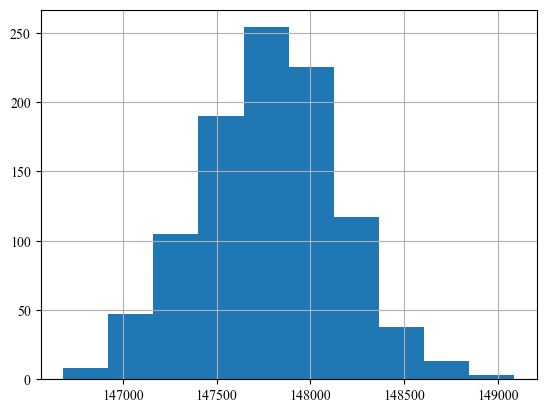

In [383]:
saved_steps_df[saved_steps_df['mi'] == 1/4]['chosen_sample']['count_order'].hist()

In [384]:
if ('mean' in OUTPUT_COLS):
    print("Mean of chosen_sample['mean'] for mi = 1/32")
    saved_steps_df[saved_steps_df['mi'] == 1/32]['chosen_sample']['mean'].hist()

In [385]:
if ('mean' in OUTPUT_COLS):
    print("Mean of release['mean'] for mi = 1/32")
    saved_steps_df[saved_steps_df['mi'] == 1/32]['release']['mean'].hist()

In [386]:
### DEBUG: Save the variables from computing the PAC noises for later reverse engineering
#if GENERATE:
#    saved_pac_variables_df = pd.DataFrame(saved_pac_variables, columns=['mi', 'out_np_0', 'fin_var', 'sqrt_total_var', 'pac_noise', 'pac_noises_to_add', 'pac_release'])
#    saved_pac_variables_df.to_parquet(f'{OUTPUT_DIR}/saved_pac_variables.parquet')
#else:
#    saved_pac_variables_df = pq.read_table(f"{OUTPUT_DIR}/saved_pac_variables.parquet").to_pandas()
#saved_pac_variables_df.head()

### Computing PAC Errors

In [387]:
# functions to calculate errors
def absolute_scaled_error(est: np.ndarray, actual: np.ndarray) -> np.ndarray:
    return np.abs(est - actual)
def relative_error_percent(est: np.ndarray, actual: np.ndarray) -> np.ndarray:
    return (np.abs(est - actual) / actual) * 100

In [388]:
#OUTPUT_COLS = OUTPUT_COLS
ERROR_COLS = [*[f'absolute error {i}' for i in OUTPUT_COLS], *[f'relative error {i}' for i in OUTPUT_COLS]]

In [389]:
print(true_result)

[3.77420000e+06 5.32075388e+09 5.05409627e+09 5.25675133e+09
 2.55375871e+01 3.60021238e+04 5.01445971e-02 1.47790000e+05]


In [390]:
true_result = np.array(runquery(lineitem_df))

(147790, 16)


In [391]:
# compute errors for PAC (or import from saved file)
if GENERATE:
    errors_list = []
    for i, row in df.iterrows():
        print(row)
        mi = row['mi']
        r = row[OUTPUT_COLS].to_numpy()
        errors_list.append([mi, *absolute_scaled_error(r, true_result), *relative_error_percent(r, true_result)])
    pac_errors_df = pd.DataFrame(errors_list, columns=['mi', *ERROR_COLS])
    pac_errors_df.to_parquet(f"{OUTPUT_DIR}/pac_errors.parquet")  # overwrite saved
else:
    pac_errors_df = pq.read_table(f"{OUTPUT_DIR}/pac_errors.parquet").to_pandas()
pac_errors_df

mi                1.248319e-03
sum_qty          -7.073586e+08
sum_base_price    4.989104e+09
sum_disc_price    4.919684e+09
sum_charge        4.197214e+09
avg_qty          -2.461113e+05
avg_price         4.386971e+07
avg_disc         -3.864512e+06
count_order      -1.030045e+08
Name: 0, dtype: float64
mi                1.248319e-03
sum_qty          -1.143785e+07
sum_base_price    5.279310e+09
sum_disc_price    5.033262e+09
sum_charge        4.338723e+09
avg_qty           4.919721e+07
avg_price         1.746626e+07
avg_disc         -3.009002e+06
count_order      -7.791579e+06
Name: 1, dtype: float64
mi                1.248319e-03
sum_qty           1.981197e+08
sum_base_price    6.169914e+09
sum_disc_price    4.714194e+09
sum_charge        5.828911e+09
avg_qty          -1.967976e+07
avg_price        -1.080161e+07
avg_disc         -2.012469e+07
count_order       2.118218e+07
Name: 2, dtype: float64
mi                1.248319e-03
sum_qty           1.116540e+09
sum_base_price    5.298379e+0

mi  absolute error sum_qty  absolute error sum_base_price  \
0      0.001248            7.111328e+08                   3.316497e+08   
1      0.001248            1.521205e+07                   4.144350e+07   
2      0.001248            1.943455e+08                   8.491605e+08   
3      0.001248            1.112766e+09                   2.237481e+07   
4      0.001248            5.569509e+08                   2.770050e+08   
...         ...                     ...                            ...   
8995  16.000000            5.294983e+06                   2.916978e+06   
8996  16.000000            1.022143e+05                   1.694319e+07   
8997  16.000000            2.362748e+06                   8.529216e+06   
8998  16.000000            2.440590e+06                   1.248159e+06   
8999  16.000000            1.647630e+06                   8.777636e+06   

      absolute error sum_disc_price  absolute error sum_charge  \
0                      1.344120e+08               1.059537e+09   
1                      2.083476e+07               9.180286e+08   
2                      3.399019e+08               5.721593e+08   
3                      6.043432e+07               9.628333e+07   
4                      8.905625e+07               2.380108e+08   
...                             ...                        ...   
8995                   4.321279e+06               5.771885e+06   
8996                   8.003628e+06               9.538140e+06   
8997                   1.270102e+06               5.088988e+06   
8998                   7.779922e+05               4.020862e+06   
8999                   5.862702e+06               7.325388e+06   

      absolute error avg_qty  absolute error avg_price  \
0               2.461369e+05              4.383370e+07   
1               4.919719e+07              1.743026e+07   
2               1.967979e+07              1.083761e+07   
3               5.816074e+07              2.173644e+07   
4               5.662576e+07              4.658261e+06   
...                      ...                       ...   
8995            3.324269e+03              3.827585e+05   
8996            3.060273e+06              1.937379e+05   
8997            3.620655e+06              6.648188e+05   
8998            1.735604e+06              6.902194e+05   
8999            8.119773e+04              6.619472e+05   

      absolute error avg_disc  absolute error count_order  \
0                3.864512e+06                1.031523e+08   
1                3.009002e+06                7.939369e+06   
2                2.012469e+07                2.103439e+07   
3                1.141621e+07                4.921089e+07   
4                1.948138e+07                3.634956e+06   
...                       ...                         ...   
8995             1.145278e+06                2.782198e+06   
8996             3.563113e+06                2.484221e+06   
8997             3.846979e+06                7.872817e+05   
8998             1.292526e+06                2.704991e+06   
8999             6.500313e+05                3.193676e+06   

      relative error sum_qty  relative error sum_base_price  \
0               18841.947289                       6.233135   
1                 403.053748                       0.778903   
2                5149.315504                      15.959402   
3               29483.483603                       0.420520   
4               14756.793714                       5.206123   
...                      ...                            ...   
8995              140.294171                       0.054823   
8996                2.708236                       0.318436   
8997               62.602621                       0.160301   
8998               64.665090                       0.023458   
8999               43.655080                       0.164970   

      relative error sum_disc_price  relative error sum_charge  \
0                          2.659467                  20.155742   
1           

In [392]:
# if GENERATE:
#     mean_df = df.groupby('mi').mean()[['count', 'sum', 'mean', 'var']]
#     std_df = df.groupby('mi').std()[['count', 'sum', 'mean', 'var']].abs()
#     mean_df, std_df

#     # save mean_df, std_df to parquet
#     mean_df.to_parquet('{OUTPUT_DIR}/pac-mean_df_student-por.parquet')
#     std_df.to_parquet('{OUTPUT_DIR}/pac-std_df_student-por.parquet')

### Computing DP Errors

### Analysis of PAC vs DP
- import the DP data
- create a dataframe (`all_df`) containing the query outputs
    - in this df, each output is the {mean, variance} aggregation over the 500 experiments, grouped by the type of privacy mechanism used (pac or dp) and privacy factor (mi or epsilon)
- create a dataframe in the same pattern containing the computed error for each privitized output

In [393]:
%%script echo skipping# Import Chais saved data from running PipelineDP and use it to compare.
dp_results_df = pq.read_table(f"{OUTPUT_DIR}/dp-q4/dp_results.parquet").to_pandas()

# compute sum from count and mean
dp_results_df['sum'] = dp_results_df['count'] * dp_results_df['mean']
dp_results_df = dp_results_df[['mi', 'count', 'sum', 'mean']]

# filter to just MI_OPTIONS
dp_results_df = dp_results_df[dp_results_df['mi'].isin(MI_OPTIONS)]

dp_results_df

skipping# Import Chais saved data from running PipelineDP and use it to compare.


In [394]:
%%script echo skipping# compute errors for DP (or import from saved file)
GENERATE_DP = True
if GENERATE_DP:
    errors_list = []
    for i, row in dp_results_df.iterrows():
        mi = row['mi']
        r = row[OUTPUT_COLS].to_numpy()
        errors_list.append([mi, *absolute_scaled_error(r, true_result), *relative_error_percent(r, true_result)])
    dp_errors_df = pd.DataFrame(errors_list, columns=['mi', *ERROR_COLS])
    dp_errors_df.to_parquet(f"{OUTPUT_DIR}/dp-q4/dp_errors.parquet")  # overwrite saved
else:
    dp_errors_df = pq.read_table(f"{OUTPUT_DIR}/dp-q4/dp_errors.parquet").to_pandas()
dp_errors_df

skipping# compute errors for DP (or import from saved file)


In [395]:
### Make one merged DF to compare results
all_df = pd.concat([  # we will call mi and epsilon the "factor" so that the schemas match
    #dp_results_df.assign(type='dp').rename(columns={'eps': 'factor'}), # switch from eps to mi for indexing DP results
    #dp_results_df.assign(type='dp').rename(columns={'mi': 'factor'}), # comment out DP results until we have some
    df.assign(type='pac').rename(columns={'mi': 'factor'})
])
all_df = all_df.groupby(['type', 'factor']).agg(['mean', 'var'])
all_df.columns = [' '.join(col).strip() for col in all_df.columns.values]  # Flatten the columns
#all_df.to_parquet(f"{OUTPUT_DIR}/all_results.parquet")  # Save the merged results
all_df

sum_qty mean   sum_qty var  sum_base_price mean  \
type factor                                                       
pac  0.001248   1.233203e+07  1.385233e+17         5.333800e+09   
     0.015625   1.641118e+05  9.734343e+15         5.322962e+09   
     0.031250   4.059796e+06  5.822671e+15         5.318979e+09   
     0.062500   4.350643e+06  2.735718e+15         5.318496e+09   
     0.250000   4.308240e+06  7.111572e+14         5.321793e+09   
     1.000000   3.281242e+06  1.695357e+14         5.321193e+09   
     2.000000   3.906419e+06  8.382104e+13         5.319906e+09   
     4.000000   3.656817e+06  4.249395e+13         5.320021e+09   
     16.000000  3.900006e+06  1.077231e+13         5.320812e+09   

                sum_base_price var  sum_disc_price mean  sum_disc_price var  \
type factor                                                                   
pac  0.001248         1.066604e+17         5.053636e+09        1.011236e+17   
     0.015625         9.499082e+15         5.052496e+09        8.384715e+15   
     0.031250         4.977753e+15         5.055865e+09        4.552687e+15   
     0.062500         2.410691e+15         5.055694e+09        2.263639e+15   
     0.250000         8.085707e+14         5.054218e+09        7.178446e+14   
     1.000000         3.941453e+14         5.054529e+09        4.007725e+14   
     2.000000         3.458079e+14         5.053152e+09        3.144675e+14   
     4.000000         3.125695e+14         5.053313e+09        2.842961e+14   
     16.000000        2.562640e+14         5.053857e+09        2.319663e+14   

                sum_charge mean  sum_charge var  avg_qty mean   avg_qty var  \
type factor                                                                   
pac  0.001248      5.252581e+09    1.415237e+17  1.914930e+06  7.842159e+16   
     0.015625      5.257053e+09    1.022816e+16 -1.245139e+06  6.363631e+15   
     0.031250      5.251446e+09    6.013957e+15 -1.027178e+06  3.138782e+15   
     0.062500      5.255850e+09    3.072705e+15  2.298956e+06  1.615478e+15   
     0.250000      5.255205e+09    8.634099e+14  5.222199e+05  4.209286e+14   
     1.000000      5.256394e+09    4.562264e+14 -1.282451e+04  1.006885e+14   
     2.000000      5.255244e+09    3.792582e+14 -9.500925e+04  4.578543e+13   
     4.000000      5.255786e+09    3.069652e+14 -7.086675e+04  2.288595e+13   
     16.000000     5.256745e+09    2.533986e+14 -2.281357e+05  6.122889e+12   

                avg_price mean  avg_price var  avg_disc mean  avg_disc var  \
type factor                                                                  
pac  0.001248    -2.701662e+06   9.497732e+15   8.975234e+06  8.232171e+16   
     0.015625    -1.073141e+06   7.851135e+14  -2.363432e+06  6.662501e+15   
     0.031250     9.913160e+05   3.715721e+14  -5.430271e+06  3.376121e+15   
     0.062500    -1.003054e+06   2.022579e+14  -9.246426e+04  1.377359e+15   
     0.250000     7.503586e+05   4.843043e+13  -6.173790e+04  3.988647e+14   
     1.000000    -1.351087e+05   1.104152e+13  -4.298991e+05  9.830533e+13   
     2.000000    -9.892479e+03   6.191151e+12  -4.080018e+04  4.849227e+13   
     4.000000     1.297506e+05   3.185738e+12  -2.173020e+05  2.537499e+13   
     16.000000    3.602894e+04   7.785080e+11   6.952058e+04  6.703280e+12   

                count_order mean  count_order var  
type factor                                        
pac  0.001248       8.871617e+06     7.773128e+16  
     0.015625       8.782444e+05     6.237308e+15  
     0.031250       1.076552e+06     3.193770e+15  
     0.062500       1.220943e+06     1.503665e+15  
     0.250000      -6.977997e+05     4.244280e+14  
     1.000000       5.341243e+05     1.043280e+14  
     2.000000       6.595189e+05     4.796370e+13  
     4.000000       2.149067e+05     2.657190e+13  
     16.000000      1.988760e+05     5.640009e+12

In [396]:
### Make another merged df for the errors
errors_df = pd.concat([  # we will call mi and epsilon the "factor" so that the schemas match
    #dp_errors_df.assign(type='dp').rename(columns={'eps': 'factor'}), # switch from eps to mi for indexing DP results
    #dp_errors_df.assign(type='dp').rename(columns={'mi': 'factor'}), # comment out DP results until we have some
    pac_errors_df.assign(type='pac').rename(columns={'mi': 'factor'})
])
errors_df = errors_df.groupby(['type', 'factor']).agg(['mean', 'var'])
# drop absolute * mean and relative * var columns from level 1
#errors_df = errors_df.drop(columns=[('absolute error count', 'mean'), ('absolute error mean', 'mean'), ('relative error count', 'var'), ('relative error mean', 'var')])
errors_df.columns = [' '.join(col).strip() for col in errors_df.columns.values]  # flatten the columns

#errors_df.to_parquet(f"{OUTPUT_DIR}/all_errors.parquet")
errors_df

absolute error sum_qty mean  absolute error sum_qty var  \
type factor                                                               
pac  0.001248                  2.744378e+08                6.320513e+16   
     0.015625                  7.421615e+07                4.233839e+15   
     0.031250                  5.490265e+07                2.805435e+15   
     0.062500                  3.848376e+07                1.253569e+15   
     0.250000                  1.975793e+07                3.206761e+14   
     1.000000                  9.659246e+06                7.638454e+13   
     2.000000                  6.821815e+06                3.725480e+13   
     4.000000                  4.733965e+06                2.007488e+13   
     16.000000                 2.404471e+06                5.000891e+12   

                absolute error sum_base_price mean  \
type factor                                          
pac  0.001248                         2.485995e+08   
     0.015625                         7.412620e+07   
     0.031250                         5.367602e+07   
     0.062500                         3.811635e+07   
     0.250000                         2.214440e+07   
     1.000000                         1.571114e+07   
     2.000000                         1.490894e+07   
     4.000000                         1.403420e+07   
     16.000000                        1.290560e+07   

                absolute error sum_base_price var  \
type factor                                         
pac  0.001248                        4.496716e+16   
     0.015625                        4.003768e+15   
     0.031250                        2.096908e+15   
     0.062500                        9.614855e+14   
     0.250000                        3.187854e+14   
     1.000000                        1.472513e+14   
     2.000000                        1.240285e+14   
     4.000000                        1.159510e+14   
     16.000000                       8.954627e+13   

                absolute error sum_disc_price mean  \
type factor                                          
pac  0.001248                         2.427772e+08   
     0.015625                         6.933885e+07   
     0.031250                         5.144309e+07   
     0.062500                         3.657367e+07   
     0.250000                         2.071687e+07   
     1.000000                         1.601538e+07   
     2.000000                         1.410055e+07   
     4.000000                         1.344643e+07   
     16.000000                        1.235124e+07   

                absolute error sum_disc_price var  \
type factor                                         
pac  0.001248                        4.212400e+16   
     0.015625                        3.574590e+15   
     0.031250                        1.906778e+15   
     0.062500                        9.272228e+14   
     0.250000                        2.882413e+14   
     1.000000                        1.442105e+14   
     2.000000                        1.163357e+14   
     4.000000                        1.039225e+14   
     16.000000                       7.931809e+13   

                absolute error sum_charge mean  absolute error sum_charge var  \
type factor                                                                     
pac  0.001248                     2.732496e+08                   6.680105e+16   
     0.015625                     7.463116e+07                   4.652862e+15   
     0.031250                     5.694149e+07                   2.796557e+15   
     0.062500                     4.201919e+07                   1.306138e+15   
     0.250000                     2.245905e+07                   3.608889e+14   
     1.000000                     1.687070e+07                   1.714490e+14   
     2.000000                     1.560622e+07                   1.377332e+14   
     4.000000                     1.399373e+07                   1.118768e+14   
     16.000000        

In [397]:
#abs_error = errors_df.groupby('mi').mean()[['absolute error count', 'absolute error sum', 'absolute error mean', 'absolute error var']]
#rel_error = errors_df.groupby('mi').mean()[['relative error count', 'relative error sum', 'relative error mean', 'relative error var']]

#std_abs_error = errors_df.groupby('mi').std()[['absolute error count', 'absolute error sum', 'absolute error mean', 'absolute error var']]
#sample_mean_rel_error = errors_df.groupby('mi').mean()[['relative error count', 'relative error sum', 'relative error mean', 'relative error var']]

# save std_abs_error, sample_mean_rel_error to parquet
# std_abs_error.to_parquet('outputs/pac-std_abs_error_student-por.parquet')
# sample_mean_rel_error.to_parquet('outputs/pac-sample_mean_rel_error_student-por.parquet')

### Plotting Results

We are reproducing Table 14 from this paper: http://arxiv.org/abs/2109.10789

> TABLE 14: Experiments of the queries count, sum, mean, and var on the attribute Absences of the Portuguese education dataset containing 649 individuals (500 experiments per ε).

In [398]:
### Imports for matplotlib
import matplotlib as mpl
#import seaborn as sns
import matplotlib.pyplot as plt
#sns.reset_orig()

# Michael's matplotlib defaults
# set font to Times New Roman
LATEX = False
if LATEX:
    mpl.rcParams['text.usetex'] = True
    mpl.rcParams["font.family"] = "serif"
    mpl.rcParams["font.serif"] = "Times"
else:
    mpl.rcParams['text.usetex'] = False
    mpl.rcParams["font.family"] = "Times New Roman"
    mpl.rcParams["mathtext.fontset"] = "stix"
    
plt.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['savefig.dpi'] = 300

import matplotlib_inline.backend_inline
#matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

mpl.rcParams['axes.titleweight'] = 'bold'

In [399]:
import matplotlib.colors as mcolors

PAC_COLOR = 'tab:blue'
DP_COLOR = 'tab:red'

# Function to lighten a color by blending with white
def lighten_color(color, amount=0.3):
    rgba = mcolors.to_rgba(color)
    return tuple(np.clip(np.array(rgba[:3]) + amount, 0, 1)) + (rgba[3],)

# Create lighter colors
PAC_LIGHT = lighten_color(PAC_COLOR, 0.3)
DP_LIGHT = lighten_color(DP_COLOR, 0.3)

# create legend, use color squares
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
pac_dp_legend_handles = [
    Patch(facecolor=PAC_COLOR, edgecolor=PAC_COLOR, label='PAC'),
    Patch(facecolor=DP_COLOR, edgecolor=DP_COLOR, label='DP')
]

Reproduction of Table 14 (PAC)

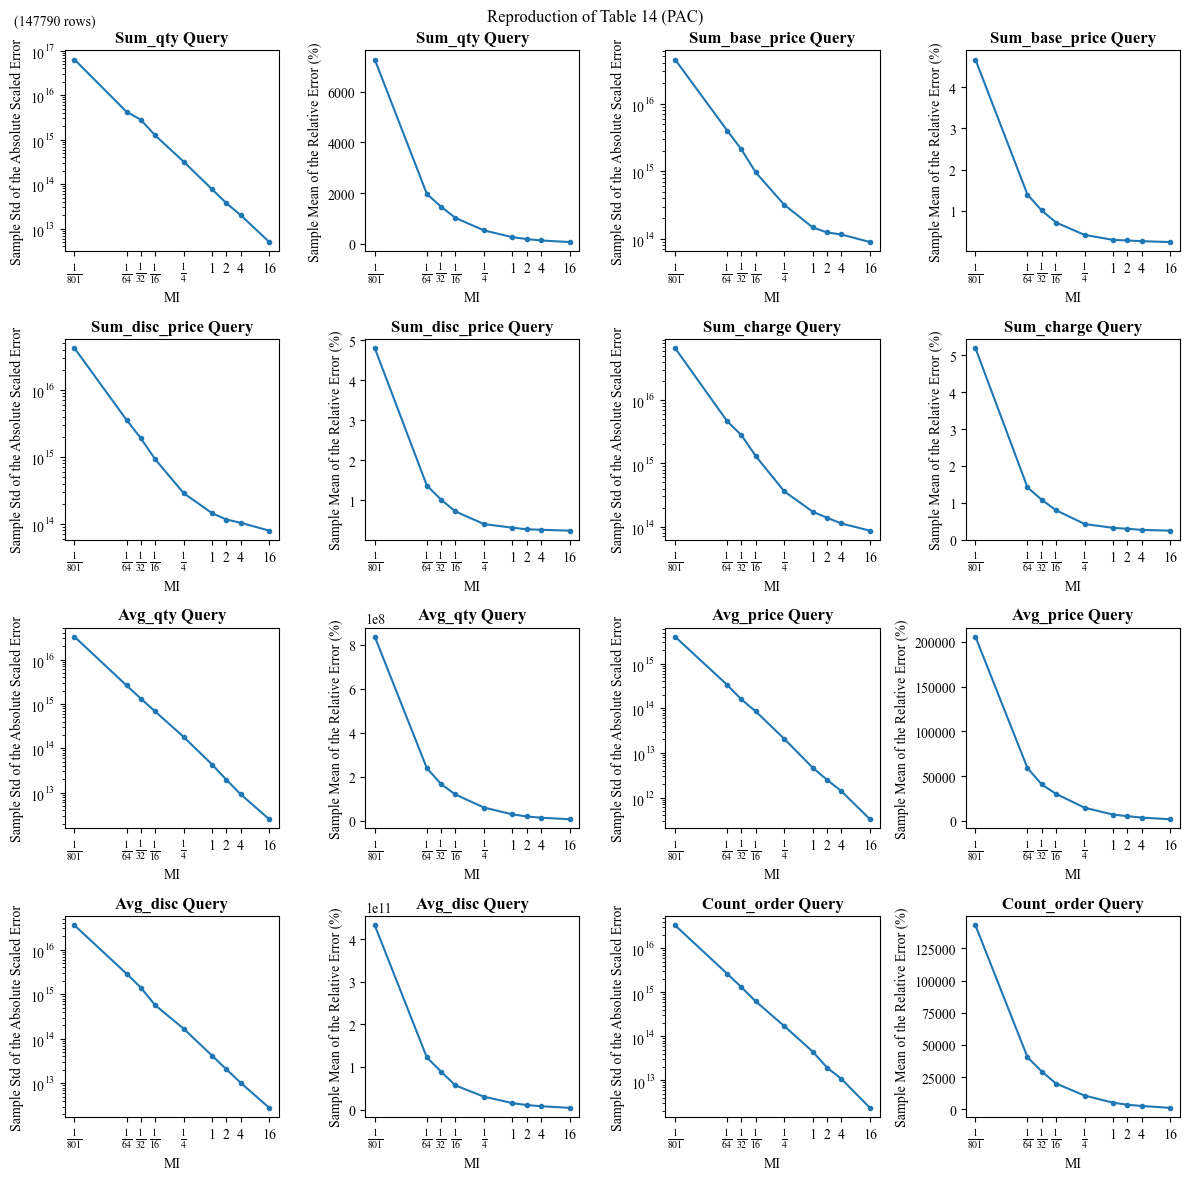

In [400]:
### Reproduction of Table 14 (PAC)
# Plotting each query type with their error metrics
fig, axs = plt.subplots(4, 4, figsize=(12, 12))
queries = OUTPUT_COLS
#MI_OPTIONS = [1/64, 1/32, 1/16, 1/4, 1., 2., 4., 16.]

# Loop through each query to create the subplots
for i, query in enumerate(queries):
    # go from top left, to top right, to bottom left, to bottom right
    row = (i*2)//4
    col = (i*2) % 4
    ax1 = axs[row][col]
    ax2 = axs[row][col+1]

    # Plotting Sample Std of Absolute Scaled Error
    TYPE = 'pac'
    d = errors_df.loc[TYPE].loc[:, f'absolute error {query} var']
    ax1.plot(d.index, d, label=query, marker='.', color=PAC_COLOR)
             #label=query, marker='.')

    ax1.set_yscale('log')

    ax1.set_xscale('log', base=2)
    xticks = MI_OPTIONS
    xlabels = [f'$\\frac{{1}}{{{int(1/x)}}}$' if x < 1 else f'{int(x)}' for x in xticks]
    ax1.set_xticks(xticks)
    ax1.set_xticklabels(xlabels)

    ax1.set_title(f'{query.capitalize()} Query')
    ax1.set_xlabel('MI')
    ax1.set_ylabel('Sample Std of the Absolute Scaled Error')

    # Plotting Sample Mean of the Relative Error (%)
    d = errors_df.loc[TYPE].loc[:, f'relative error {query} mean']
    ax2.plot(d.index, d, label=query, marker='.', color=PAC_COLOR)

    ax2.set_xscale('log', base=2)
    xticks = MI_OPTIONS
    xlabels = [f'$\\frac{{1}}{{{int(1/x)}}}$' if x < 1 else f'{int(x)}' for x in xticks]
    ax2.set_xticks(xticks)
    ax2.set_xticklabels(xlabels)

    ax2.set_title(f'{query.capitalize()} Query')
    ax2.set_xlabel('MI')
    ax2.set_ylabel('Sample Mean of the Relative Error (%)')

# add label in top left corner "sum = count * mean"
#fig.text(0.75, 0.95, '(sum = count * mean)', ha='center', va='center')
fig.text(0.05, 0.97, f'({number_of_contributing_rows} rows)', ha='center', va='center')
fig.suptitle("Reproduction of Table 14 (PAC)")
plt.tight_layout()
fig.savefig(f"{OUTPUT_DIR}/table14_pac.jpg", bbox_inches='tight')
plt.show()

Reproduction of Table 14 (DP)

In [401]:
%%script echo skipping### Reproduction of Table 14 (DP)
# Plotting each query type with their error metrics
fig, axs = plt.subplots(2, 4, figsize=(12, 6))
queries = OUTPUT_COLS
#MI_OPTIONS = [1/256, 1/128, 1/64, 1/16, 1/4, 1., 2., 4., 16.]

# Loop through each query to create the subplots
for i, query in enumerate(queries):
    # go from top left, to top right, to bottom left, to bottom right
    row = (i*2)//4
    col = (i*2) % 4
    ax1 = axs[row][col]
    ax2 = axs[row][col+1]

    # Plotting Sample Std of Absolute Scaled Error
    TYPE = 'dp'
    d = errors_df.loc[TYPE].loc[:, f'absolute error {query} var']
    ax1.plot(d.index, d, label=query, marker='.', color=DP_COLOR)
             #label=query, marker='.')
    
    ax1.set_yscale('log')

    ax1.set_xscale('log', base=2)
    xticks = MI_OPTIONS
    xlabels = [f'$\\frac{{1}}{{{int(1/x)}}}$' if x < 1 else f'{int(x)}' for x in xticks]
    ax1.set_xticks(xticks)
    ax1.set_xticklabels(xlabels)

    ax1.set_title(f'{query.capitalize()} Query')
    ax1.set_xlabel('MI')
    ax1.set_ylabel('Sample Std of the Absolute Scaled Error')

    # Plotting Sample Mean of the Relative Error (%)
    d = errors_df.loc[TYPE].loc[:, f'relative error {query} mean']
    ax2.plot(d.index, d, label=query, marker='.', color=DP_COLOR)

    ax2.set_xscale('log', base=2)
    xticks = MI_OPTIONS
    xlabels = [f'$\\frac{{1}}{{{int(1/x)}}}$' if x < 1 else f'{int(x)}' for x in xticks]
    ax2.set_xticks(xticks)
    ax2.set_xticklabels(xlabels)

    ax2.set_title(f'{query.capitalize()} Query')
    ax2.set_xlabel('MI')
    ax2.set_ylabel('Sample Mean of the Relative Error (%)')

fig.suptitle("Reproduction of Table 14 (DP)")
plt.tight_layout()
fig.savefig(f"{OUTPUT_DIR}/table14_dp.jpg", bbox_inches='tight')
plt.show()

skipping### Reproduction of Table 14 (DP)


Both on the same axes, aligned

In [402]:
%%script echo skipping
### Both on the same axes, aligned
# Plotting each query type with their error metrics
fig, axs = plt.subplots(2, 4, figsize=(12, 6))
queries = OUTPUT_COLS
#MI_OPTIONS = [1/256, 1/128, 1/64, 1/32, 1/16, 1/4, 1., 2., 4., 16.]

# Loop through each query to create the subplots
for i, query in enumerate(queries):
    # go from top left, to top right, to bottom left, to bottom right
    row = (i*2)//4
    col = (i*2) % 4
    ax1 = axs[row][col]
    ax2 = axs[row][col+1]

    # Plotting Sample Std of Absolute Scaled Error
    d = errors_df.loc['pac'].loc[:, f'absolute error {query} var']
    ax1.plot(d.index, d, label=query, marker='.', color=PAC_COLOR)

    d = errors_df.loc['dp'].loc[:, f'absolute error {query} var']
    #print(d)
    ax1.plot(d.index, d, label=query, marker='.', color=DP_COLOR)

    ax1.set_xscale('log', base=2)
    xticks = MI_OPTIONS
    xlabels = [f'$\\frac{{1}}{{{int(1/x)}}}$' if x < 1 else f'{int(x)}' for x in xticks]
    ax1.set_xticks(xticks)
    ax1.set_xticklabels(xlabels)

    ax1.set_title(f'{query.capitalize()} Query')
    ax1.set_ylabel('Sample Std of the Absolute Scaled Error')
    ax1.set_xlabel('MI')

    # Plotting Sample Mean of the Relative Error (%)
    d = errors_df.loc['pac'].loc[:, f'relative error {query} mean']
    ax2.plot(d.index, d, label=query, marker='.', color=PAC_COLOR)

    d = errors_df.loc['dp'].loc[:, f'relative error {query} mean']
    ax2.plot(d.index, d, label=query, marker='.', color=DP_COLOR)
    
    ax2.set_xscale('log', base=2)
    xticks = MI_OPTIONS
    xlabels = [f'$\\frac{{1}}{{{int(1/x)}}}$' if x < 1 else f'{int(x)}' for x in xticks]
    ax2.set_xticks(xticks)
    ax2.set_xticklabels(xlabels)

    ax2.set_title(f'{query.capitalize()} Query')
    ax2.set_ylabel('Sample Mean of the Relative Error (%)')
    ax2.set_xlabel('MI')

# add label in top left corner "sum = count * mean"
#fig.text(0.75, 0.94, '(sum = count * mean)', ha='center', va='center')

fig.legend(handles=pac_dp_legend_handles, loc='upper right', frameon=False)

fig.text(0.05, 0.97, f'({number_of_contributing_rows} rows)', ha='center', va='center')
fig.suptitle("Reproduction of Table 14 (PAC vs DP)")
plt.tight_layout()
fig.savefig(f"{OUTPUT_DIR}/table14_pac_vs_dp.jpg", bbox_inches='tight')
plt.show()

skipping


# Additonal Extra Plotting

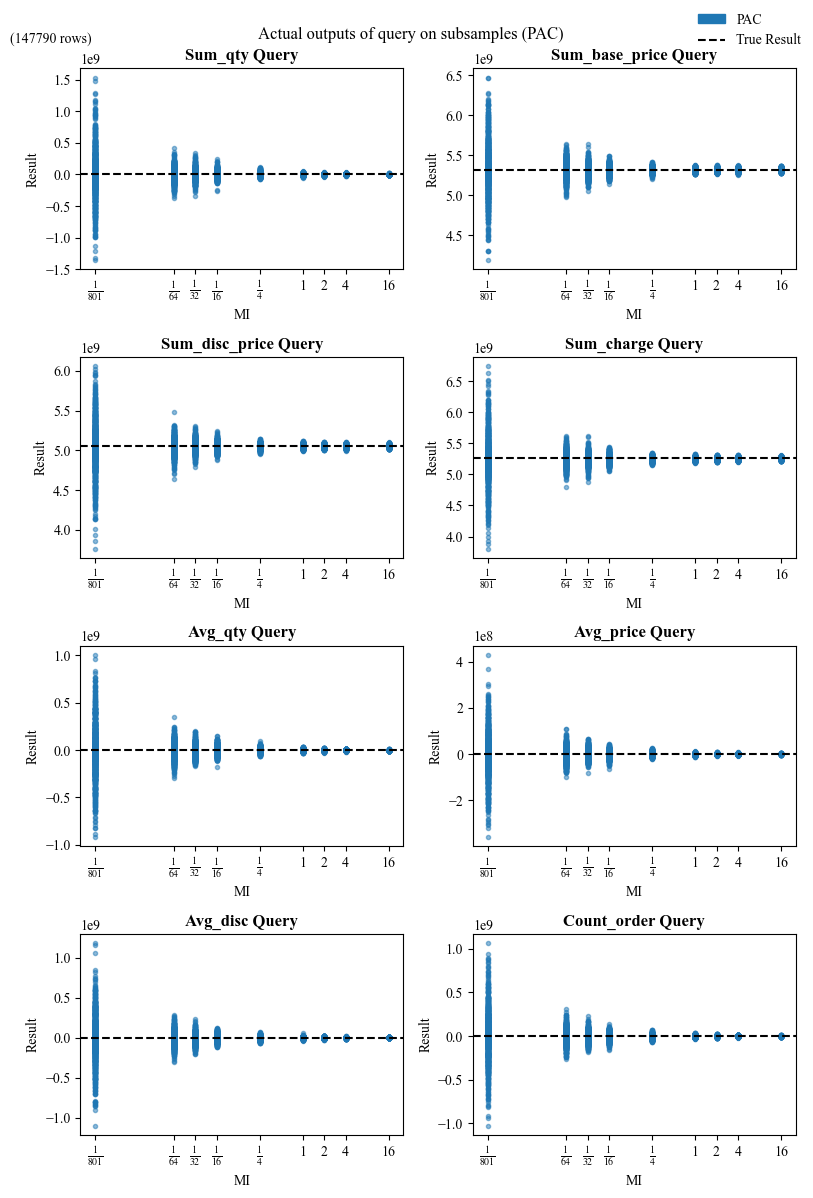

In [403]:
### Plotting the actual experiment outputs used (PAC)
# Plotting each query type with their error metrics
fig, axs = plt.subplots(4, 2, figsize=(8,12))
queries = OUTPUT_COLS
#MI_OPTIONS = [1/64, 1/32, 1/16, 1/4, 1., 2., 4., 16.]

# Loop through each query to create the subplots
for i, query in enumerate(queries):
    # go from top left, to top right, to bottom left, to bottom right
    row = i//2
    col = i%2
    ax = axs[row][col]

    TYPE = 'pac'
    ax.scatter(df['mi'], df[query], label=query, marker='.', alpha=0.5, color=PAC_COLOR)
    
    ax.axhline(y=true_result[i], color='black', linestyle='--', label='True Result')

    #for mi in MI_OPTIONS:
        #d = df.iloc[:, [0, i]].where(df['mi'] == mi).dropna()
        #ax.scatter(d.iloc[:, 0], d.iloc[:, 1], label=query, marker='.', alpha=0.5, color=PAC_COLOR)
        #ax.boxplot(d.iloc[:, 1], positions=[mi], widths=0.1, showfliers=False)
    
    ax.set_xscale('log', base=2)
    xticks = MI_OPTIONS
    xlabels = [f'$\\frac{{1}}{{{int(1/x)}}}$' if x < 1 else f'{int(x)}' for x in xticks]
    ax.set_xticks(xticks)
    ax.set_xticklabels(xlabels)

    ax.set_title(f'{query.capitalize()} Query')
    ax.set_xlabel('MI')
    ax.set_ylabel('Result')

fig.legend(handles=[
    Patch(facecolor=PAC_COLOR, edgecolor=PAC_COLOR, label='PAC'),
    Line2D([0], [0], color='black', linestyle='--', label='True Result')
], loc='upper right', frameon=False)

# add label in top left corner "sum = count * mean"
#fig.text(0.75, 0.94, '(sum = count * mean)', ha='center', va='center')
fig.text(0.05, 0.97, f'({number_of_contributing_rows} rows)', ha='center', va='center')
fig.suptitle("Actual outputs of query on subsamples (PAC)")
plt.tight_layout()
fig.savefig(f"{OUTPUT_DIR}/actual_outputs_pac.jpg", bbox_inches='tight')
plt.show()

In [404]:
%%script echo skipping### Plotting the actual experiment outputs used (DP)
# Plotting each query type with their error metrics
fig, axs = plt.subplots(2, 2, figsize=(8, 6))
queries = OUTPUT_COLS
#MI_OPTIONS = [1/256, 1/128, 1/64, 1/16, 1/4, 1., 2., 4., 16.]

# Loop through each query to create the subplots
for i, query in enumerate(queries):
    # go from top left, to top right, to bottom left, to bottom right
    row = i//2
    col = i%2
    ax = axs[row][col]

    TYPE = 'dp'

    ax.scatter(dp_results_df['mi'], dp_results_df[query], label=query, marker='.', alpha=0.5, color=DP_COLOR)
    ax.axhline(y=true_result[i], color='black', linestyle='--', label='True Result')

    ax.set_xscale('log', base=2)
    xticks = MI_OPTIONS
    xlabels = [f'$\\frac{{1}}{{{int(1/x)}}}$' if x < 1 else f'{int(x)}' for x in xticks]
    ax.set_xticks(xticks)
    ax.set_xticklabels(xlabels)

    ax.set_title(f'{query.capitalize()} Query')
    ax.set_xlabel('MI')
    ax.set_ylabel('Result')

fig.legend(handles=[
    Patch(facecolor=DP_COLOR, edgecolor=DP_COLOR, label='DP'),
    Line2D([0], [0], color='black', linestyle='--', label='True Result')
], loc='upper right', frameon=False)

# add label in top left corner "sum = count * mean"
#fig.text(0.75, 0.94, '(sum = count * mean)', ha='center', va='center')

fig.suptitle("Actual outputs of query trials (DP)")
plt.tight_layout()
fig.savefig(f"{OUTPUT_DIR}/actual_outputs_dp.jpg", bbox_inches='tight')
plt.show()

skipping### Plotting the actual experiment outputs used (DP)


In [405]:
%%script echo skipping### Both, but with side by side fig, axs = plt.subplots(2, 2, figsize=(8, 6))
fig, axs = plt.subplots(2, 2, figsize=(8, 6))
queries = OUTPUT_COLS
#MI_OPTIONS = [1/256, 1/128, 1/64, 1/32, 1/16, 1/4, 1., 2., 4., 16.]

# Loop through each query to create the subplots
for i, query in enumerate(queries):
    # go from top left, to top right, to bottom left, to bottom right
    row = i//2
    col = i%2
    ax = axs[row][col]

    ax.linewidth = 0.25

    # correct answer
    ax.axhline(y=true_result[i], color='gray', linestyle='--', label='True Result')

    for mi in MI_OPTIONS: # categorical variable
        position = MI_OPTIONS.index(mi) * 2

        TYPE = 'pac'

        pac_style = {
            'boxprops': dict(facecolor=PAC_LIGHT),
            'medianprops': dict(color='black')
        }
        
        # mi = mi and query is correct
        d = df[df['mi'] == mi][query].values
        ax.boxplot(d, positions=[position], widths=0.6, patch_artist=True, showfliers=False, **pac_style)

        position += 1
        TYPE = 'dp'

        dp_style = {
            'boxprops': dict(facecolor=DP_LIGHT),
            'medianprops': dict(color='black')
        }

        # mi = mi and query is correct
        d = dp_results_df[dp_results_df['mi'] == mi][query].values
        ax.boxplot(d, positions=[position], widths=0.6, patch_artist=True, showfliers=False, **dp_style)
    
    
    
    # override xticks, one for each pair of boxplots
    # the x axis is actually artificial here to plot both PAC and DP side by side
    xticks = [0.5+2*i for i in range(len(MI_OPTIONS))]
    ax.set_xticks(xticks)

    xlabels = [f'$\\frac{{1}}{{{int(1/x)}}}$' if x < 1 else f'{int(x)}' for x in MI_OPTIONS]
    ax.set_xticklabels(xlabels)

    ax.set_title(f'{query.capitalize()} Query')
    ax.set_xlabel('MI')
    ax.set_ylabel('Result')

fig.legend(handles=[
    Patch(facecolor=PAC_COLOR, edgecolor=PAC_COLOR, label='PAC'),
    Patch(facecolor=DP_COLOR, edgecolor=DP_COLOR, label='DP'),
    Line2D([0], [0], color='gray', linestyle='--', label='True Result')
], loc='upper right', frameon=False)

# add label in top left corner "sum = count * mean"
#fig.text(0.75, 0.94, '(sum = count * mean)', ha='center', va='center')
fig.text(0.05, 0.97, f'({number_of_contributing_rows} rows)', ha='center', va='center')
fig.suptitle("Actual outputs of query trials (PAC vs DP)")
plt.tight_layout()
fig.savefig(f"{OUTPUT_DIR}/actual_outputs_dp_vs_pac.jpg", bbox_inches='tight')
plt.show()


skipping### Both, but with side by side fig, axs = plt.subplots(2, 2, figsize=(8, 6))


In [406]:
df.groupby('mi').var()

sum_qty  sum_base_price  sum_disc_price    sum_charge  \
mi                                                                      
0.001248   1.385233e+17    1.066604e+17    1.011236e+17  1.415237e+17   
0.015625   9.734343e+15    9.499082e+15    8.384715e+15  1.022816e+16   
0.031250   5.822671e+15    4.977753e+15    4.552687e+15  6.013957e+15   
0.062500   2.735718e+15    2.410691e+15    2.263639e+15  3.072705e+15   
0.250000   7.111572e+14    8.085707e+14    7.178446e+14  8.634099e+14   
1.000000   1.695357e+14    3.941453e+14    4.007725e+14  4.562264e+14   
2.000000   8.382104e+13    3.458079e+14    3.144675e+14  3.792582e+14   
4.000000   4.249395e+13    3.125695e+14    2.842961e+14  3.069652e+14   
16.000000  1.077231e+13    2.562640e+14    2.319663e+14  2.533986e+14   

                avg_qty     avg_price      avg_disc   count_order  
mi                                                                 
0.001248   7.842159e+16  9.497732e+15  8.232171e+16  7.773128e+16  
0.015625   6.363631e+15  7.851135e+14  6.662501e+15  6.237308e+15  
0.031250   3.138782e+15  3.715721e+14  3.376121e+15  3.193770e+15  
0.062500   1.615478e+15  2.022579e+14  1.377359e+15  1.503665e+15  
0.250000   4.209286e+14  4.843043e+13  3.988647e+14  4.244280e+14  
1.000000   1.006885e+14  1.104152e+13  9.830533e+13  1.043280e+14  
2.000000   4.578543e+13  6.191151e+12  4.849227e+13  4.796370e+13  
4.000000   2.288595e+13  3.185738e+12  2.537499e+13  2.657190e+13  
16.000000  6.122889e+12  7.785080e+11  6.703280e+12  5.640009e+12

In [407]:
# tables
from plottable import ColumnDefinition, Table
from plottable.cmap import normed_cmap

In [408]:
print("Scale of noise added to [Count, Mean] (scale param passed to Normal noise function)")
saved_steps_df[['mi','scale']].groupby('mi').mean()

Scale of noise added to [Count, Mean] (scale param passed to Normal noise function)


step              scale                                              \
query           sum_qty sum_base_price sum_disc_price    sum_charge   
mi                                                                    
0.001248  -4.822696e+15   7.641400e+15  -1.275645e+16 -5.669690e+15   
0.015625  -3.852967e+14   6.104897e+14  -1.019143e+15 -4.529651e+14   
0.031250  -1.926483e+14   3.052448e+14  -5.095715e+14 -2.264826e+14   
0.062500  -9.632417e+13   1.526224e+14  -2.547858e+14 -1.132413e+14   
0.250000  -2.408104e+13   3.815561e+13  -6.369644e+13 -2.831032e+13   
1.000000  -6.020261e+12   9.538902e+12  -1.592411e+13 -7.077580e+12   
2.000000  -3.010130e+12   4.769451e+12  -7.962055e+12 -3.538790e+12   
4.000000  -1.505065e+12   2.384725e+12  -3.981028e+12 -1.769395e+12   
16.000000 -3.762663e+11   5.961813e+11  -9.952569e+11 -4.423488e+11   

step                                                               
query           avg_qty     avg_price      avg_disc   count_order  
mi                                                                 
0.001248   8.188438e+15 -2.426656e+15  8.479288e+15  8.085771e+15  
0.015625   6.541939e+14 -1.938714e+14  6.774306e+14  6.459916e+14  
0.031250   3.270970e+14 -9.693569e+13  3.387153e+14  3.229958e+14  
0.062500   1.635485e+14 -4.846785e+13  1.693577e+14  1.614979e+14  
0.250000   4.088712e+13 -1.211696e+13  4.233941e+13  4.037447e+13  
1.000000   1.022178e+13 -3.029240e+12  1.058485e+13  1.009362e+13  
2.000000   5.110890e+12 -1.514620e+12  5.292427e+12  5.046809e+12  
4.000000   2.555445e+12 -7.573101e+11  2.646213e+12  2.523405e+12  
16.000000  6.388613e+11 -1.893275e+11  6.615533e+11  6.308511e+11

Comparison of how much noise is added to the data, by looking at the variance of the distributions from which noise is sampled.

In [409]:
%%script echo skipping # Wait until we have DP data to compare
dp_var_noise = {  # from pipelinedp repo, dp_basic_mean_variances.csv
    #0.00390625: 0.2784089313555703,
    #0.0078125: 0.19648087910574175,
    0.015625: 0.13837628104247293,
    0.0625: 0.06750340282072995,
    0.25: 0.03001721300521553,
    1.0: 0.004282722801885366,
    2.0: 0.004282722801885366,
    4.0: 0.004282722801885366,
    16.0: 0.004282722801885366
}
d = dp_var_noise
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
plt.plot(d.keys(), d.values(), marker='.', label='DP', color=DP_COLOR)
plt.xlabel('MI')
ax.set_xticks(list(d.keys()))
ax.set_xticklabels([f'$\\frac{{1}}{{{int(1/x)}}}$' if x < 1 else f'{int(x)}' for x in d.keys()])
plt.suptitle('Noise added by DP to Mean query (scale param passed to Laplace noise function)')
plt.title('DP')
plt.savefig(f"{OUTPUT_DIR}/noise_distribution_scale_meanquery_dp.jpg", bbox_inches='tight')
plt.show()

skipping # Wait until we have DP data to compare


In [410]:
#assert not any(any(saved_steps_df[['mi','scale']].groupby('mi').var().values)) # assume we are only computing scale once per MI
if ('mean' in OUTPUT_COLS):
    pac_var_noise = dict(zip(MI_OPTIONS, saved_steps_df[['mi','scale']].groupby('mi').mean()[[('scale','mean')]].to_numpy().flatten()))
    pac_var_noise

In [411]:
# Let's compute the same for PAC: what is the scale of the distribution from which noise is sampled to add to PAC?
if ('mean' in OUTPUT_COLS): 
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    d = pac_var_noise
    plt.plot(d.keys(), d.values(), marker='.', label='PAC', color=PAC_COLOR)
    plt.xlabel('MI')
    ax.set_xticks(list(d.keys()))
    ax.set_xticklabels([f'$\\frac{{1}}{{{int(1/x)}}}$' if x < 1 else f'{int(x)}' for x in d.keys()])
    plt.suptitle('Noise added by PAC to Mean query (scale param passed to Normal noise function)')
    plt.title('PAC')
    plt.savefig(f"{OUTPUT_DIR}/noise_distribution_scale_meanquery_pac.jpg", bbox_inches='tight')
    plt.show()

In [412]:
# How much of PAC error is due to sampling? Compute % error on our samples before noise was added
sample_errors = [relative_error_percent(s, true_result) for s in saved_steps_df['chosen_sample'].to_numpy()]
sample_errors_df = pd.DataFrame(sample_errors, columns=OUTPUT_COLS)
sample_errors_df.insert(0, 'mi', saved_steps_df['mi'].values)  # Insert 'mi' at the beginning
print("PAC: Error from Subsampling (as % of true_result, without any noise being added)")
#print("First output: overall mean / Second output: grouped by MI")
display(sample_errors_df[OUTPUT_COLS].mean())
display(sample_errors_df.groupby('mi').mean())

PAC: Error from Subsampling (as % of true_result, without any noise being added)


sum_qty           0.243649
sum_base_price    0.249651
sum_disc_price    0.249610
sum_charge        0.249847
avg_qty           0.116544
avg_price         0.125655
avg_disc          0.132807
count_order       0.210451
dtype: float64

sum_qty  sum_base_price  sum_disc_price  sum_charge   avg_qty  \
mi                                                                          
0.001248   0.244688        0.251550        0.251787    0.252200  0.113948   
0.015625   0.241447        0.247017        0.246790    0.247212  0.118504   
0.031250   0.251744        0.258144        0.257963    0.258496  0.114920   
0.062500   0.244855        0.250054        0.249886    0.249943  0.115539   
0.250000   0.233003        0.240890        0.240767    0.240499  0.116940   
1.000000   0.247243        0.254637        0.254864    0.255344  0.122471   
2.000000   0.249389        0.252500        0.252076    0.251873  0.118962   
4.000000   0.248174        0.252223        0.252249    0.252330  0.113764   
16.000000  0.232298        0.239846        0.240108    0.240728  0.113852   

           avg_price  avg_disc  count_order  
mi                                           
0.001248    0.122967  0.134339     0.211024  
0.015625    0.127820  0.127322     0.210060  
0.031250    0.126225  0.135912     0.220084  
0.062500    0.127394  0.131311     0.208658  
0.250000    0.126918  0.135546     0.204179  
1.000000    0.130890  0.133659     0.210864  
2.000000    0.126852  0.126916     0.213726  
4.000000    0.120794  0.134733     0.213937  
16.000000   0.121029  0.135526     0.201526

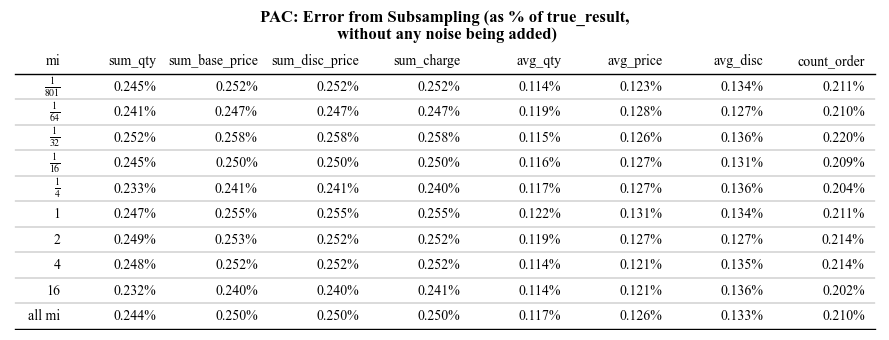

In [413]:
d=sample_errors_df.groupby('mi').mean()
d.loc['all mi'] = sample_errors_df[OUTPUT_COLS].mean()

fig, ax = plt.subplots(figsize=(5+(0.5*len(d.columns)), 3.5))

col_defs = [
    ColumnDefinition(
        name=d.index.name,
        #textprops={"ha": "right"},
        width=0.25,
        formatter=lambda x: (f'$\\frac{{1}}{{{int(1/x)}}}$' if x < 1 else f'{int(x)}') if type(x) != str else x,
    ),
    *[ColumnDefinition(
        name=c,
        textprops={"ha": "right"},
        width=0.5,
        formatter=lambda x: f"{x:.3f}%",
    ) for c in d.columns]]
tbl = Table(d,
    column_definitions=col_defs,
    row_dividers=True,
    footer_divider=True,
    ax=ax,
    #textprops={"fontsize": 14},
    #row_divider_kw={"linewidth": 1, "linestyle": (0, (1, 5))},
    #col_label_divider_kw={"linewidth": 1, "linestyle": "-"},
    #column_border_kw={"linewidth": 1, "linestyle": "-"},
    )
plt.title("PAC: Error from Subsampling (as % of true_result,\n without any noise being added)")
plt.tight_layout()
fig.savefig(f"{OUTPUT_DIR}/tbl-pac_sample_error.jpg", bbox_inches='tight')
plt.show()

In [414]:
print("PAC: How much noise are we adding? (actual noise amounts sampled from the normal distribution, absolute value)")
# abs before mean
saved_steps_df[['mi', 'chosen_noise']].apply(lambda x: np.abs(x)).groupby('mi').mean().rename(columns={'chosen_noise': 'abs(chosen_noise)'})

PAC: How much noise are we adding? (actual noise amounts sampled from the normal distribution, absolute value)


/var/folders/g4/jxkqkb_d5170qh291jwd0t_h0000gn/T/ipykernel_79564/2429859456.py:3: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  saved_steps_df[['mi', 'chosen_noise']].apply(lambda x: np.abs(x)).groupby('mi').mean().rename(columns={'chosen_noise': 'abs(chosen_noise)'})


step      abs(chosen_noise)                                              \
query               sum_qty sum_base_price sum_disc_price    sum_charge   
mi                                                                        
0.001248       2.744380e+08   2.473286e+08   2.416032e+08  2.729617e+08   
0.015625       7.421610e+07   7.262342e+07   6.753828e+07  7.341786e+07   
0.031250       5.490290e+07   5.216413e+07   4.897828e+07  5.455122e+07   
0.062500       3.848363e+07   3.515960e+07   3.417658e+07  3.977300e+07   
0.250000       1.975823e+07   1.726808e+07   1.692524e+07  1.865446e+07   
1.000000       9.659688e+06   8.771948e+06   8.978542e+06  9.604003e+06   
2.000000       6.822046e+06   5.929773e+06   5.965927e+06  6.608917e+06   
4.000000       4.734163e+06   4.357983e+06   4.157669e+06  4.691322e+06   
16.000000      2.404718e+06   2.242234e+06   2.231204e+06  2.345227e+06   

step                                                               
query           avg_qty     avg_price      avg_disc   count_order  
mi                                                                 
0.001248   2.138933e+08  7.401559e+07  2.169879e+08  2.110675e+08  
0.015625   6.124691e+07  2.123489e+07  6.138025e+07  5.988228e+07  
0.031250   4.270261e+07  1.465287e+07  4.463101e+07  4.345001e+07  
0.062500   3.066091e+07  1.085669e+07  2.838470e+07  2.968152e+07  
0.250000   1.550625e+07  5.314931e+06  1.518173e+07  1.590848e+07  
1.000000   7.602187e+06  2.538180e+06  7.545234e+06  7.714480e+06  
2.000000   5.123460e+06  1.922385e+06  5.286109e+06  5.352746e+06  
4.000000   3.704839e+06  1.342767e+06  3.897448e+06  3.964428e+06  
16.000000  1.912135e+06  6.725783e+05  1.974949e+06  1.803239e+06

/var/folders/g4/jxkqkb_d5170qh291jwd0t_h0000gn/T/ipykernel_79564/211596906.py:1: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  d = saved_steps_df[['mi', 'chosen_noise']].apply(lambda x: np.abs(x)).groupby('mi').mean().rename(columns={'chosen_noise': 'abs(chosen_noise)'})


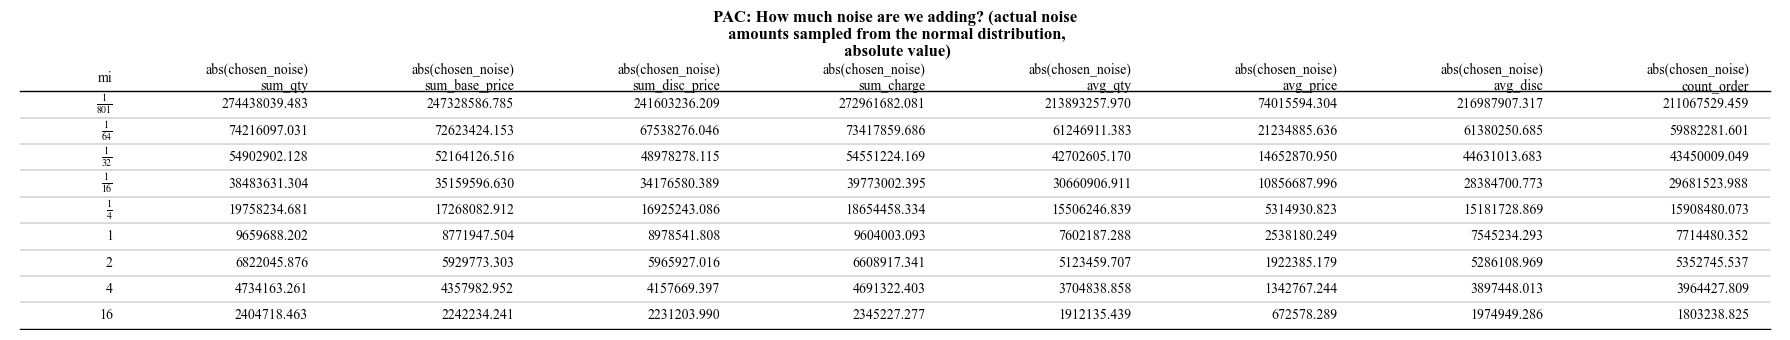

In [415]:
d = saved_steps_df[['mi', 'chosen_noise']].apply(lambda x: np.abs(x)).groupby('mi').mean().rename(columns={'chosen_noise': 'abs(chosen_noise)'})

fig, ax = plt.subplots(figsize=(2+(2*len(d.columns)), 3.5))

col_defs = [
    ColumnDefinition(
        name=d.index.name,
        #textprops={"ha": "right"},
        width=0.25,
        formatter=lambda x: (f'$\\frac{{1}}{{{int(1/x)}}}$' if x < 1 else f'{int(x)}') if type(x) != str else x,
    ),
    *[ColumnDefinition(
        name=c,
        title='\n'.join(c),
        textprops={"ha": "right"},
        width=0.5,
        formatter=lambda x: f"{x:.3f}",
    ) for c in d.columns]]
tbl = Table(d,
    column_definitions=col_defs,
    row_dividers=True,
    footer_divider=True,
    ax=ax,
    #textprops={"fontsize": 14},
    #row_divider_kw={"linewidth": 1, "linestyle": (0, (1, 5))},
    #col_label_divider_kw={"linewidth": 1, "linestyle": "-"},
    #column_border_kw={"linewidth": 1, "linestyle": "-"},
    )
plt.title("PAC: How much noise are we adding? (actual noise\n amounts sampled from the normal distribution,\n absolute value)")
plt.tight_layout()
fig.savefig(f"{OUTPUT_DIR}/tbl-pac_chosen_noise.jpg", bbox_inches='tight')
plt.show()

In [416]:
print("Avg. value of unnoised sample used by PAC")
display(saved_steps_df[['mi', 'chosen_sample']].groupby('mi').mean())  # average per MI, shouldn't be different
display(saved_steps_df[['chosen_sample']].mean().to_frame(name='all mi').T)  # sample shouldn't change with MI, so we can find the overall average

Avg. value of unnoised sample used by PAC


/var/folders/g4/jxkqkb_d5170qh291jwd0t_h0000gn/T/ipykernel_79564/883409176.py:2: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  display(saved_steps_df[['mi', 'chosen_sample']].groupby('mi').mean())  # average per MI, shouldn't be different


step      chosen_sample                                              \
query           sum_qty sum_base_price sum_disc_price    sum_charge   
mi                                                                    
0.001248    3774210.388   5.320744e+09   5.054105e+09  5.256769e+09   
0.015625    3774391.064   5.320879e+09   5.054237e+09  5.256905e+09   
0.031250    3774247.654   5.321014e+09   5.054357e+09  5.257015e+09   
0.062500    3774388.952   5.321101e+09   5.054427e+09  5.257088e+09   
0.250000    3774175.572   5.320772e+09   5.054099e+09  5.256746e+09   
1.000000    3774296.374   5.321076e+09   5.054411e+09  5.257073e+09   
2.000000    3773444.918   5.319687e+09   5.053061e+09  5.255668e+09   
4.000000    3773759.092   5.320080e+09   5.053457e+09  5.256091e+09   
16.000000   3774191.602   5.320625e+09   5.053964e+09  5.256627e+09   

step                                                      
query        avg_qty     avg_price  avg_disc count_order  
mi                                                        
0.001248   25.535431  35998.916937  0.050143  147802.892  
0.015625   25.537384  36000.863241  0.050140  147798.656  
0.031250   25.537914  36003.887949  0.050143  147789.966  
0.062500   25.537678  36002.795421  0.050146  147796.864  
0.250000   25.538915  36004.348860  0.050145  147781.372  
1.000000   25.537662  36003.486910  0.050144  147793.340  
2.000000   25.536545  36000.638634  0.050147  147766.470  
4.000000   25.536093  35999.661066  0.050144  147781.374  
16.000000  25.536914  36000.380497  0.050149  147793.584

step   chosen_sample                                                         \
query        sum_qty sum_base_price sum_disc_price    sum_charge    avg_qty   
all mi  3.774123e+06   5.320664e+09   5.054013e+09  5.256665e+09  25.537171   

step                                           
query      avg_price  avg_disc    count_order  
all mi  36001.664391  0.050145  147789.390889

/var/folders/g4/jxkqkb_d5170qh291jwd0t_h0000gn/T/ipykernel_79564/3303776140.py:1: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  d = saved_steps_df[['mi', 'chosen_sample']].groupby('mi').mean()


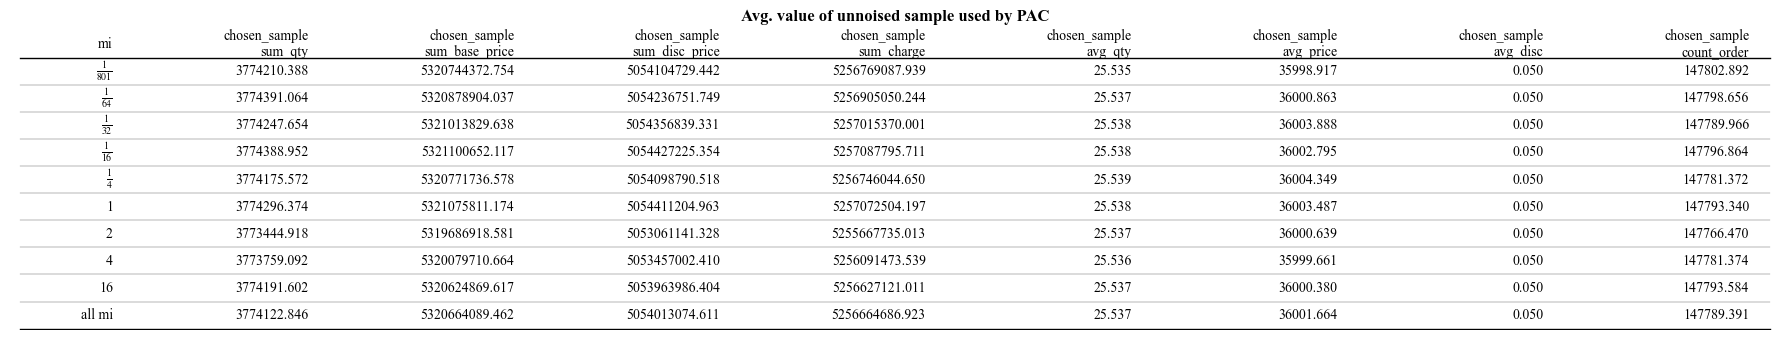

In [417]:
d = saved_steps_df[['mi', 'chosen_sample']].groupby('mi').mean()
d.loc['all mi'] = saved_steps_df[['chosen_sample']].mean()

fig, ax = plt.subplots(figsize=(2+(2*len(d.columns)), 3.5))

col_defs = [
    ColumnDefinition(
        name=d.index.name,
        #textprops={"ha": "right"},
        width=0.25,
        formatter=lambda x: (f'$\\frac{{1}}{{{int(1/x)}}}$' if x < 1 else f'{int(x)}') if type(x) != str else x,
    ),
    *[ColumnDefinition(
        name=c,
        title='\n'.join(c),
        textprops={"ha": "right"},
        width=0.5,
        formatter=lambda x: f"{x:.3f}",
    ) for c in d.columns]]
tbl = Table(d,
    column_definitions=col_defs,
    row_dividers=True,
    footer_divider=True,
    ax=ax,
    #textprops={"fontsize": 14},
    #row_divider_kw={"linewidth": 1, "linestyle": (0, (1, 5))},
    #col_label_divider_kw={"linewidth": 1, "linestyle": "-"},
    #column_border_kw={"linewidth": 1, "linestyle": "-"},
    )
plt.title("Avg. value of unnoised sample used by PAC")
plt.tight_layout()
fig.savefig(f"{OUTPUT_DIR}/tbl-pac_unnoised_samples.jpg", bbox_inches='tight')
plt.show()

In [418]:
# How much total error is there in PAC? Compute % error on our samples after noise was added
total_errors = [relative_error_percent(s, true_result) for s in saved_steps_df['release'].to_numpy()]
total_errors_df = pd.DataFrame(total_errors, columns=OUTPUT_COLS)
total_errors_df.insert(0, 'mi', saved_steps_df['mi'].values)  # Insert 'mi' at the beginning
print("PAC: Total Error (as % of true_result)")
total_errors_df.groupby('mi').mean()

PAC: Total Error (as % of true_result)


sum_qty  sum_base_price  sum_disc_price  sum_charge  \
mi                                                                   
0.001248   7271.416049        4.672261        4.803572    5.198069   
0.015625   1966.407389        1.393152        1.371934    1.419720   
0.031250   1454.683040        1.008805        1.017849    1.083207   
0.062500   1019.653530        0.716371        0.723644    0.799338   
0.250000    523.499777        0.416189        0.409903    0.427242   
1.000000    255.928303        0.295280        0.316879    0.320934   
2.000000    180.748636        0.280204        0.278993    0.296880   
4.000000    125.429639        0.263763        0.266050    0.266205   
16.000000    63.708087        0.242552        0.244381    0.245886   

                avg_qty      avg_price      avg_disc    count_order  
mi                                                                   
0.001248   8.375625e+08  205586.745399  4.327244e+11  142815.838532  
0.015625   2.398305e+08   58982.310592  1.224065e+11   40518.496451  
0.031250   1.672147e+08   40700.018569  8.900463e+10   29399.827544  
0.062500   1.200619e+08   30155.685231  5.660570e+10   20083.579146  
0.250000   6.071931e+07   14762.831735  3.027590e+10   10764.246261  
1.000000   2.976862e+07    7050.082155  1.504695e+10    5219.905274  
2.000000   2.006243e+07    5339.642893  1.054173e+10    3621.867457  
4.000000   1.450740e+07    3729.688846  7.772419e+09    2682.497491  
16.000000  7.487534e+06    1868.166045  3.938509e+09    1220.134002

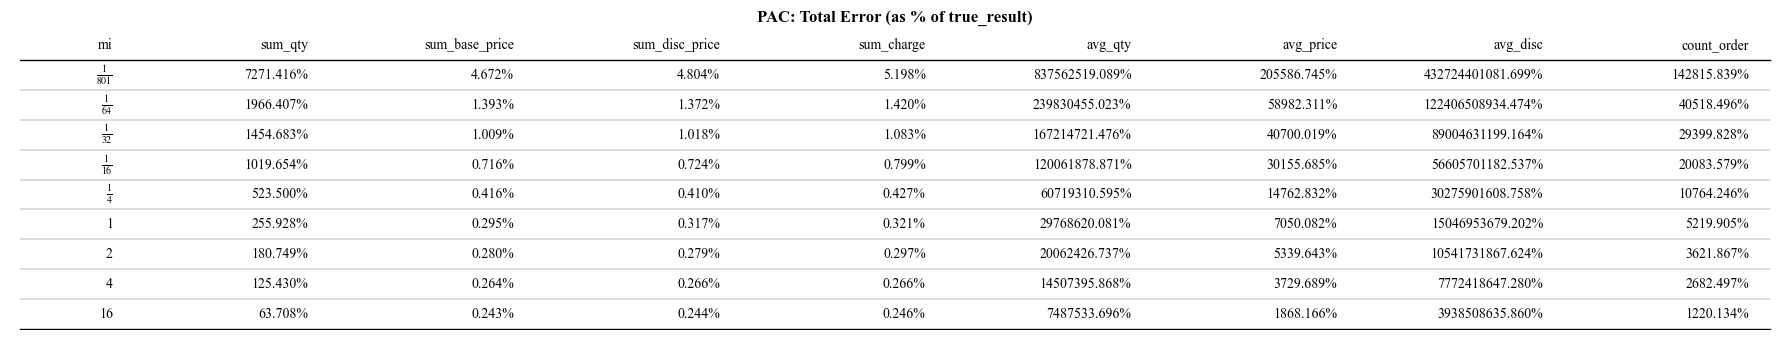

In [419]:
d=total_errors_df.groupby('mi').mean()

fig, ax = plt.subplots(figsize=(2+(2*len(d.columns)), 3.5))

col_defs = [
    ColumnDefinition(
        name=d.index.name,
        #textprops={"ha": "right"},
        width=0.25,
        formatter=lambda x: f'$\\frac{{1}}{{{int(1/x)}}}$' if x < 1 else f'{int(x)}',
    ),
    *[ColumnDefinition(
        name=c,
        textprops={"ha": "right"},
        width=0.5,
        formatter=lambda x: f"{x:.3f}%",
    ) for c in d.columns]]
tbl = Table(d,
    column_definitions=col_defs,
    row_dividers=True,
    footer_divider=True,
    ax=ax,
    #textprops={"fontsize": 14},
    #row_divider_kw={"linewidth": 1, "linestyle": (0, (1, 5))},
    #col_label_divider_kw={"linewidth": 1, "linestyle": "-"},
    #column_border_kw={"linewidth": 1, "linestyle": "-"},
    )
plt.title("PAC: Total Error (as % of true_result)")
plt.tight_layout()
fig.savefig(f"{OUTPUT_DIR}/tbl-pac_error_total.jpg", bbox_inches='tight')
plt.show()

In [420]:
print("PAC: Increase in Avg. % error due to noise being added (as % of true_result)")
delta_error_from_noise = pd.concat(
    [
        saved_steps_df['mi'].reset_index(drop=True),
        pd.DataFrame(
            (np.array([relative_error_percent(s, true_result) for s in saved_steps_df['release'].to_numpy()]) -
             np.array([relative_error_percent(s, true_result) for s in saved_steps_df['chosen_sample'].to_numpy()])),
            columns=OUTPUT_COLS
        )
    ],
    axis=1
)
delta_error_from_noise.groupby('mi').mean()

PAC: Increase in Avg. % error due to noise being added (as % of true_result)


sum_qty  sum_base_price  sum_disc_price  sum_charge  \
mi                                                                   
0.001248   7271.171361        4.420712        4.551785    4.945870   
0.015625   1966.165942        1.146135        1.125143    1.172509   
0.031250   1454.431296        0.750661        0.759887    0.824711   
0.062500   1019.408675        0.466317        0.473758    0.549394   
0.250000    523.266775        0.175300        0.169135    0.186743   
1.000000    255.681060        0.040643        0.062015    0.065590   
2.000000    180.499247        0.027703        0.026917    0.045006   
4.000000    125.181464        0.011540        0.013801    0.013875   
16.000000    63.475789        0.002706        0.004273    0.005159   

                avg_qty      avg_price      avg_disc    count_order  
mi                                                                   
0.001248   8.375625e+08  205586.622432  4.327244e+11  142815.627509  
0.015625   2.398305e+08   58982.182772  1.224065e+11   40518.286391  
0.031250   1.672147e+08   40699.892344  8.900463e+10   29399.607460  
0.062500   1.200619e+08   30155.557837  5.660570e+10   20083.370488  
0.250000   6.071931e+07   14762.704817  3.027590e+10   10764.042082  
1.000000   2.976862e+07    7049.951264  1.504695e+10    5219.694410  
2.000000   2.006243e+07    5339.516041  1.054173e+10    3621.653731  
4.000000   1.450740e+07    3729.568052  7.772419e+09    2682.283554  
16.000000  7.487534e+06    1868.045016  3.938509e+09    1219.932475

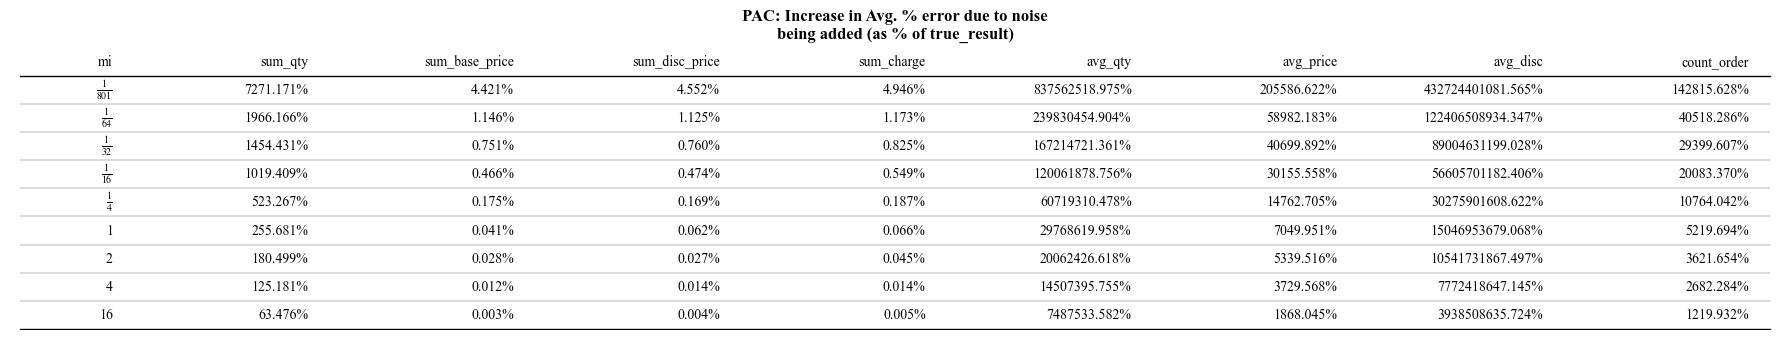

In [421]:
d=delta_error_from_noise.groupby('mi').mean()

fig, ax = plt.subplots(figsize=(2+(2*len(d.columns)), 3.5))

col_defs = [
    ColumnDefinition(
        name=d.index.name,
        #textprops={"ha": "right"},
        width=0.25,
        formatter=lambda x: f'$\\frac{{1}}{{{int(1/x)}}}$' if x < 1 else f'{int(x)}',
    ),
    *[ColumnDefinition(
        name=c,
        textprops={"ha": "right"},
        width=0.5,
        formatter=lambda x: f"{x:.3f}%",
    ) for c in d.columns]]
tbl = Table(d,
        column_definitions=col_defs,
        row_dividers=True,
        footer_divider=True,
        ax=ax,
        )
plt.title("PAC: Increase in Avg. % error due to noise\nbeing added (as % of true_result)")
plt.tight_layout()
fig.savefig(f"{OUTPUT_DIR}/tbl-pac_error_noise.jpg", bbox_inches='tight')
plt.show()

In [422]:
sample_errors_df.head()

mi   sum_qty  sum_base_price  sum_disc_price  sum_charge   avg_qty  \
0  0.001248  0.224789        0.131269        0.131315    0.136426  0.174806   
1  0.001248  0.142812        0.122127        0.119284    0.125781  0.004785   
2  0.001248  0.154947        0.105837        0.088380    0.092110  0.027775   
3  0.001248  0.136082        0.085049        0.094843    0.104280  0.014110   
4  0.001248  0.394150        0.482914        0.494476    0.484132  0.396867   

   avg_price  avg_disc  count_order  
0   0.081239  0.003250     0.050071  
1   0.015929  0.113781     0.138034  
2   0.021398  0.175139     0.127208  
3   0.065066  0.097846     0.150213  
4   0.485634  0.178249     0.002707

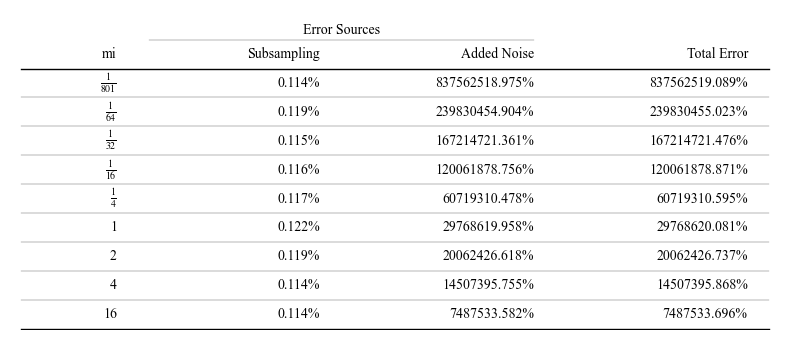

In [423]:
### Combined % Error Table
d = pd.concat([
    sample_errors_df[['mi', 'avg_qty']].groupby('mi').mean(),  # % error from subsampling
    delta_error_from_noise[['mi','avg_qty']].groupby('mi').mean(),  # % error from noise
    total_errors_df[['mi','avg_qty']].groupby('mi').mean(),  # % total error
], axis=1)
d.columns = ['Subsampling', 'Added Noise', 'Total Error']

fig, ax = plt.subplots(figsize=(2+(2*len(d.columns)), 3.5))

col_defs = [
    ColumnDefinition(
        name=d.index.name,
        #textprops={"ha": "right"},
        width=0.25,
        formatter=lambda x: f'$\\frac{{1}}{{{int(1/x)}}}$' if x < 1 else f'{int(x)}',
    ),
    *[ColumnDefinition(
        name=c,
        group="Error Sources",
        textprops={"ha": "right"},
        width=0.5,
        formatter=lambda x: f"{x:.3f}%",
    ) for c in d.columns[:-1]],
    ColumnDefinition(
        name=d.columns[-1],
        textprops={"ha": "right"},
        width=0.5,
        formatter=lambda x: f"{x:.3f}%",
    )]
tbl = Table(d,
            column_definitions=col_defs,
            row_dividers=True,
            footer_divider=True,
            ax=ax,
        )
#plt.title("PAC: Error Breakdown")
plt.tight_layout()
fig.savefig(f"{OUTPUT_DIR}/tbl-pac_error_breakdown.jpg", bbox_inches='tight')
plt.show()

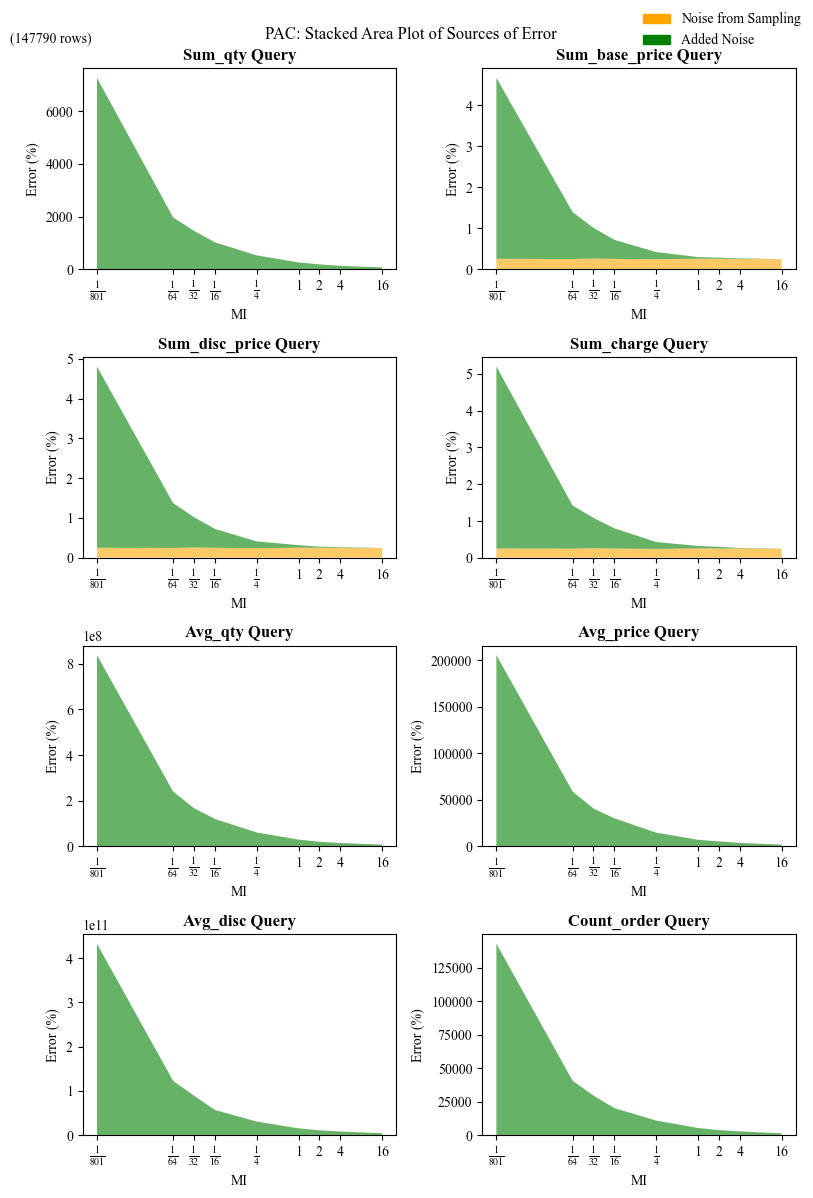

In [424]:
fig, axs = plt.subplots(4, 2, figsize=(8, 12))

psample_errors = sample_errors_df.groupby('mi').mean()
pnoise_errors = delta_error_from_noise.groupby('mi').mean()

for i, query in enumerate(OUTPUT_COLS):
    row = i//2
    col = i%2
    ax = axs[row][col]

    ax.stackplot(psample_errors.index, psample_errors[query], pnoise_errors[query], 
        labels=['Sample Error', 'Noise Error'], colors=['orange', 'green'], alpha=0.6)
    
    ax.set_xscale('log', base=2)
    xticks = MI_OPTIONS
    xlabels = [f'$\\frac{{1}}{{{int(1/x)}}}$' if x < 1 else f'{int(x)}' for x in xticks]
    ax.set_xticks(xticks)
    ax.set_xticklabels(xlabels)


    ax.set_title(f'{query.capitalize()} Query')
    ax.set_xlabel('MI')
    ax.set_ylabel('Error (%)')

fig.legend(handles=[
    Patch(facecolor='orange', edgecolor='orange', label='Noise from Sampling'),
    Patch(facecolor='green', edgecolor='green', label='Added Noise'),
], loc='upper right', frameon=False)

# add label in top left corner "sum = count * mean"
fig.text(0.05, 0.97, f'({number_of_contributing_rows} rows)', ha='center', va='center')
fig.suptitle("PAC: Stacked Area Plot of Sources of Error")
plt.tight_layout()
fig.savefig(f"{OUTPUT_DIR}/pac_error_breakdown.jpg", bbox_inches='tight')
plt.show()